<a href="https://colab.research.google.com/github/adinissim-160495/bci4als/blob/master/new2_CHIST_ERA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installations

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install pytorch-lightning
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pytorch-lightning
!{sys.executable} -m pip install lightning-bolts
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install mne-features
!{sys.executable} -m pip install fitter
!{sys.executable} -m pip install google
!{sys.executable} -m pip install mne
!{sys.executable} -m pip install mne-connectivity
!{sys.executable} -m pip install yasa
!{sys.executable} -m pip install --upgrade networkx
!{sys.executable} -m pip install networkx matplotlib




In [2]:
import torch
import scipy.io
import scipy
import mne
from scipy import signal
import pytorch_lightning as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import FastICA

from mne_features.feature_extraction import FeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
from torch.nn import functional as F
from torch import nn
# from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import norm, wasserstein_distance
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
import mne
from mne.channels import make_standard_montage
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne import find_events
from scipy.signal import spectrogram
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

mne.set_log_level(verbose=False)
# Load the TensorBoard notebook extension
%load_ext tensorboard

# load and orgnize data

In [3]:
subID = '201' # As str 201, 205, 206
eyesFlag = 'OO' # str        CC --> closed,   OO --> open
drive.mount('/content/gdrive', force_remount=True)
# !ls "/content/gdrive/My Drive/Colab Notebooks/Data2AdamWojciechovski"
dataDir = '/content/gdrive/My Drive/Colab Notebooks/Data2AdamWojciechovski/Data2Share'
# dataDir = 'C:/Users/adini/Desktop/Data2AdamWojciechovski'
dayNumber = range(0,200) # Array of the desired days number
block = [1]
trialLen = 3 # In seconds
filterLim = [1, 40] # In Hz

Mounted at /content/gdrive


In [4]:
# load and orgnize data

def getRecording(dataDir, subID, eyesCondition, day, block=[1]):
    """
    Iterate over days given, of specific subject and get a list of all the files of the relevant days
    """

    data = []
    dirPath = dataDir + '/sub' + subID + '/RA' + eyesCondition
    for day_i in day:
        dayStr = str(day_i)
        if len(dayStr) == 1:
            dayStr = '0' + dayStr
        for block_i in block:
          try:
              fileFormat = 'sub' + subID + '-day' + dayStr + '-block' + str(block_i) + '-condRA' + eyesCondition + '.mat'
              data.append(scipy.io.loadmat(dirPath + '/' +fileFormat))
          except:
            pass

    return data

def extractData(eegDict):
    """
    Arrange the given dictionary to more comfort dictionary
    """
    # EEG will be channels_N X timestamps_N
    EEG = eegDict['dat']['X'][0][0].T
    # Triggers
    triggers = np.squeeze(eegDict['dat']['Y'][0][0])
    # Artifacts marker
    artifacts = np.squeeze(eegDict['dat']['E'][0][0])
    # Sampling rate
    fs = eegDict['header']['sampleFreq'][0][0][0][0]
    # Electrodes labels
    chanLabels = [ch[0] for ch in eegDict['header']['Xlabels'][0][0][0]]
    # Triggers labels
    trigLabels = [trig[0] for trig in eegDict['header']['Ymarkers'][0][0][0]]
    # Trials time (in secs)
    imagineLength = eegDict['paramRA']['c_robot'][0][0][0][0]
    idleLength = eegDict['paramRA']['b_pause'][0][0][0][0]

    Data = {'EEG': EEG, 'triggers': triggers, 'artifacts': artifacts, 'fs': fs,
           'chanLabels': chanLabels, 'trigLabels': trigLabels, 'imagineLength': imagineLength,
           'idleLength': idleLength}
    return Data

def segmentEEG(eegArrangedDict, trialLen, printFlag = 1):
    """
    Segment the data into epochs of MI and idle.
    """
    EEG = []
    labels = []
    removedCount = 0
    idleCount = 0
    imagineCount = 0

    # Timestamps of "move" command
    imgIdx = np.where(eegArrangedDict['triggers'] == 3)[0]
    # Timestamps of 1st pause
    idleIdx = np.where(eegArrangedDict['triggers'] == 2)[0]
    for idx in imgIdx:
        # Check that the trial is atleast as the given trial length (not ended before)
        if np.sum(eegArrangedDict['artifacts'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) > 0:
            removedCount += 1
        elif np.sum(eegArrangedDict['triggers'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) == 0:
            EEG.append(eegArrangedDict['EEG'][:, idx : idx + int(trialLen * eegArrangedDict['fs'])])
            labels.append(1)
            imagineCount += 1
        else:
            removedCount += 1

    for idx in idleIdx:
        if np.sum(eegArrangedDict['artifacts'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) > 0:
            removedCount += 1
        else:
            EEG.append(eegArrangedDict['EEG'][:, idx : idx + int(trialLen * eegArrangedDict['fs'])])
            labels.append(0)
            idleCount += 1

    # Add to the dictionary the segmented data
    eegArrangedDict['segmentedEEG'] = np.asarray(EEG)
    eegArrangedDict['labels'] = np.asarray(labels)

    if printFlag:
        # Print number of trials of each class and number of removed trials
        print(f'Imagine Trials-{imagineCount} \nIdle Trials- {idleCount} \nRemoved Trials- {removedCount}\n')

    # Return the dictionary
    return eegArrangedDict

def stackBlocks(eegDictList, block_N):
    """
    Stack blocks from same day into one EEG + labels dictionary
    """
    stackedList = []
    count = 0
    for i, eegDict in enumerate(eegDictList):
        if i % block_N == 0:
            tempArray = eegDict['segmentedEEG']
            tempLabels = eegDict['labels']
        else:
            tempArray = np.concatenate((tempArray, eegDict['segmentedEEG']))
            tempLabels = np.concatenate((tempLabels, eegDict['labels']))
            count += 1
        if count == block_N - 1:
            stackedDict = {'segmentedEEG': tempArray, 'labels': tempLabels, 'fs': eegDict['fs'],
           'chanLabels': eegDict['chanLabels'], 'trigLabels': eegDict['trigLabels'], 'trials_N': len(tempLabels)}
            stackedList.append(stackedDict)
            count = 0

    return stackedList

def EEG_filter(interData,filterLim):

    # Band pass filter
    b, a = signal.butter(4, np.array([filterLim[0],filterLim[1]])/(interData['fs']/2), btype='bandpass')
    eeg_key = 'EEG' if 'EEG' in interData else 'segmentedEEG'
    filtered_data = signal.filtfilt(b, a, interData[eeg_key].astype('float'))
    # ICA filter
    ica = FastICA(n_components=interData[eeg_key].shape[0], random_state=20)
    filtered_data = ica.fit_transform(filtered_data.T).T

    return filtered_data

def EEG_filter_3D(interData, filterLim):

    eeg_key = 'EEG' if 'EEG' in interData else 'segmentedEEG'
    filtered_data = np.empty_like(interData[eeg_key])
    for i in range(interData[eeg_key].shape[0]):
      trail = interData[eeg_key][i,:,:]
      b, a = signal.butter(4, np.array([filterLim[0],filterLim[1]])/(interData['fs']/2), btype='bandpass')
      filtered_trail = signal.filtfilt(b, a, trail.astype('float'))
      # ICA filter
      ica = FastICA(n_components=trail.shape[0], random_state=20)
      filtered_trail = ica.fit_transform(filtered_trail.T).T
      filtered_data[i,:,:] = filtered_trail
    return filtered_data


# def EEG_filter_3D(interData, filterLim): # the change from the above one is that this function get the eeg data in 3D : (trials, channels, time)
#     # Determine the right key for EEG data ('EEG' or 'segmentedEEG')
#     eeg_key = 'EEG' if 'EEG' in interData else 'segmentedEEG'
#     eeg_data = interData[eeg_key].astype('float')

#     # Band-pass filter setup
#     fs = interData['fs']
#     b, a = signal.butter(4, np.array(filterLim) / (fs / 2), btype='bandpass')

#     filtered_data = np.empty_like(eeg_data)

#     # Apply band-pass filter trial by trial
#     for i in range(eeg_data.shape[0]):  # Assuming eeg_data is shaped as (trials, channels, time)
#         for j in range(eeg_data.shape[1]):  # Iterating over channels
#             filtered_data[i, j, :] = signal.filtfilt(b, a, eeg_data[i, j, :])

#     # Initialize a list to hold the ICA filtered data
#     ica_filtered_data = np.empty_like(filtered_data)

#     # Apply ICA for each trial
#     for i in range(filtered_data.shape[0]):
#         trial_data = filtered_data[i, :, :]  # Shape: (channels, time)

#         # FastICA expects data in shape (samples, features), so no need to transpose here
#         ica = FastICA(n_components=trial_data.shape[0], random_state=20, max_iter=200)

#         # Fit and transform the data - note that we transpose back after transformation
#         ica_filtered_data[i, :, :] = ica.fit_transform(trial_data.T).T  # Shape back to (channels, time)

#     return ica_filtered_data

# Function to merge list of dictionaries
def merge_dicts(dict_list):
    merged_dict = dict_list[0]
    for d in range(1,len(dict_list)):
        merged_dict['segmentedEEG'] = np.concatenate((merged_dict['segmentedEEG'], dict_list[d]['segmentedEEG']), 0)
        merged_dict['labels'] = np.append(merged_dict['labels'],dict_list[d]['labels'])
        merged_dict['trials_N'] = merged_dict['trials_N'] + dict_list[d]['trials_N']
    return merged_dict

def dicts_of_10_days(list_of_dicts):
  # Create an empty list to store the new dictionaries
  new_list_of_dicts = []

  # Loop through list_of_dicts in steps of 10
  for i in range(0, len(list_of_dicts), 10):
    # Slice the original list to get the next 10 dictionaries
    slice_of_dicts = list_of_dicts[i:i + 10]

    # Merge the slice of dictionaries
    merged_dict = merge_dicts(slice_of_dicts)

    # Append the merged dictionary to the new list
    new_list_of_dicts.append(merged_dict)
  return(new_list_of_dicts)

In [ ]:
# # load data- dont need when its already saved in pickle ;)

# # Load all relevant days files into list
# # drive.mount('/content/gdrive')
# dataList = getRecording(dataDir, subID, eyesFlag, dayNumber, block)

# # Extract and segment all the data
# dictList = []
# for dayData in dataList:
# # Extract each day data
#     interData = extractData(dayData)
# # Filter the data
#     eegMat = EEG_filter(interData, filterLim)
# #     interData['EEG'] = applyICA(eegMat, eegInfo, [0], plotFlag=0)
# # Segment the data
#     dictList.append(segmentEEG(interData, trialLen, printFlag=0))

# # Stack block of same day
# dictListStacked = stackBlocks(dictList, len(block))

In [5]:
with open('/content/gdrive/My Drive/Colab Notebooks/denoised_dict_train_size30_OO.pickle', 'rb') as file:
    denoised_data_dict = pickle.load(file)
with open('/content/gdrive/My Drive/Colab Notebooks/dictListStacked.pickle', 'rb') as file:
    dictListStacked = pickle.load(file)



In [6]:
data_30_AE = merge_dicts(denoised_data_dict[:30])
data_30 = merge_dicts(dictListStacked[:30])
# data_30_AE['filtered_data'] = EEG_filter_3D(data_30_AE,filterLim)

In [7]:
data_30_50_AE = merge_dicts(denoised_data_dict[30:50])
data_30_50 = merge_dicts(dictListStacked[30:50])
# data_30_50_AE['filtered_data'] = EEG_filter_3D(data_30_50_AE,filterLim)

# Visual overview of the data

In [9]:
def plot_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(unique, counts, tick_label=['Idle', 'Movement'])
    plt.xlabel('Condition')
    plt.ylabel('Number of Trials')
    plt.title('Distribution of Trial Labels')
    plt.show()


In [10]:
def plot_erp(eeg_data, eeg_key):
    # Calculate average signals for movement (1) and idle (0) labels
    movement_trials = eeg_data[eeg_key][eeg_data['labels'] == 1]
    idle_trials = eeg_data[eeg_key][eeg_data['labels'] == 0]

    movement_erp = np.mean(movement_trials, axis=0)
    idle_erp = np.mean(idle_trials, axis=0)

    # Plotting
    time_points = np.arange(movement_erp.shape[1])
    time_axis = time_points / eeg_data['fs']
    plt.figure(figsize=(20, 15))
    for i, channel in enumerate(eeg_data['chanLabels']):
        plt.subplot(len(eeg_data['chanLabels']), 1, i+1)
        plt.plot(time_axis, movement_erp[i, :], label='Movement')
        plt.plot(time_axis, idle_erp[i, :], label='Idle', linestyle='--')
        plt.title(f'Channel: {channel}')
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()



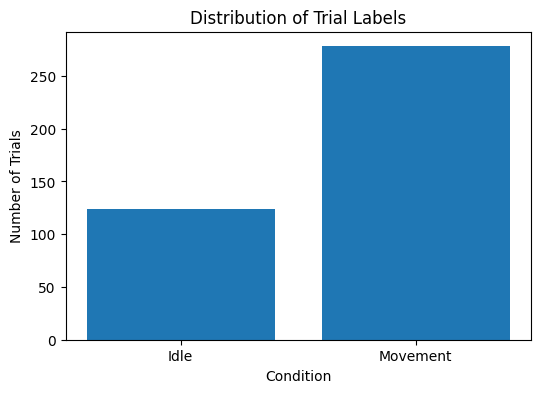

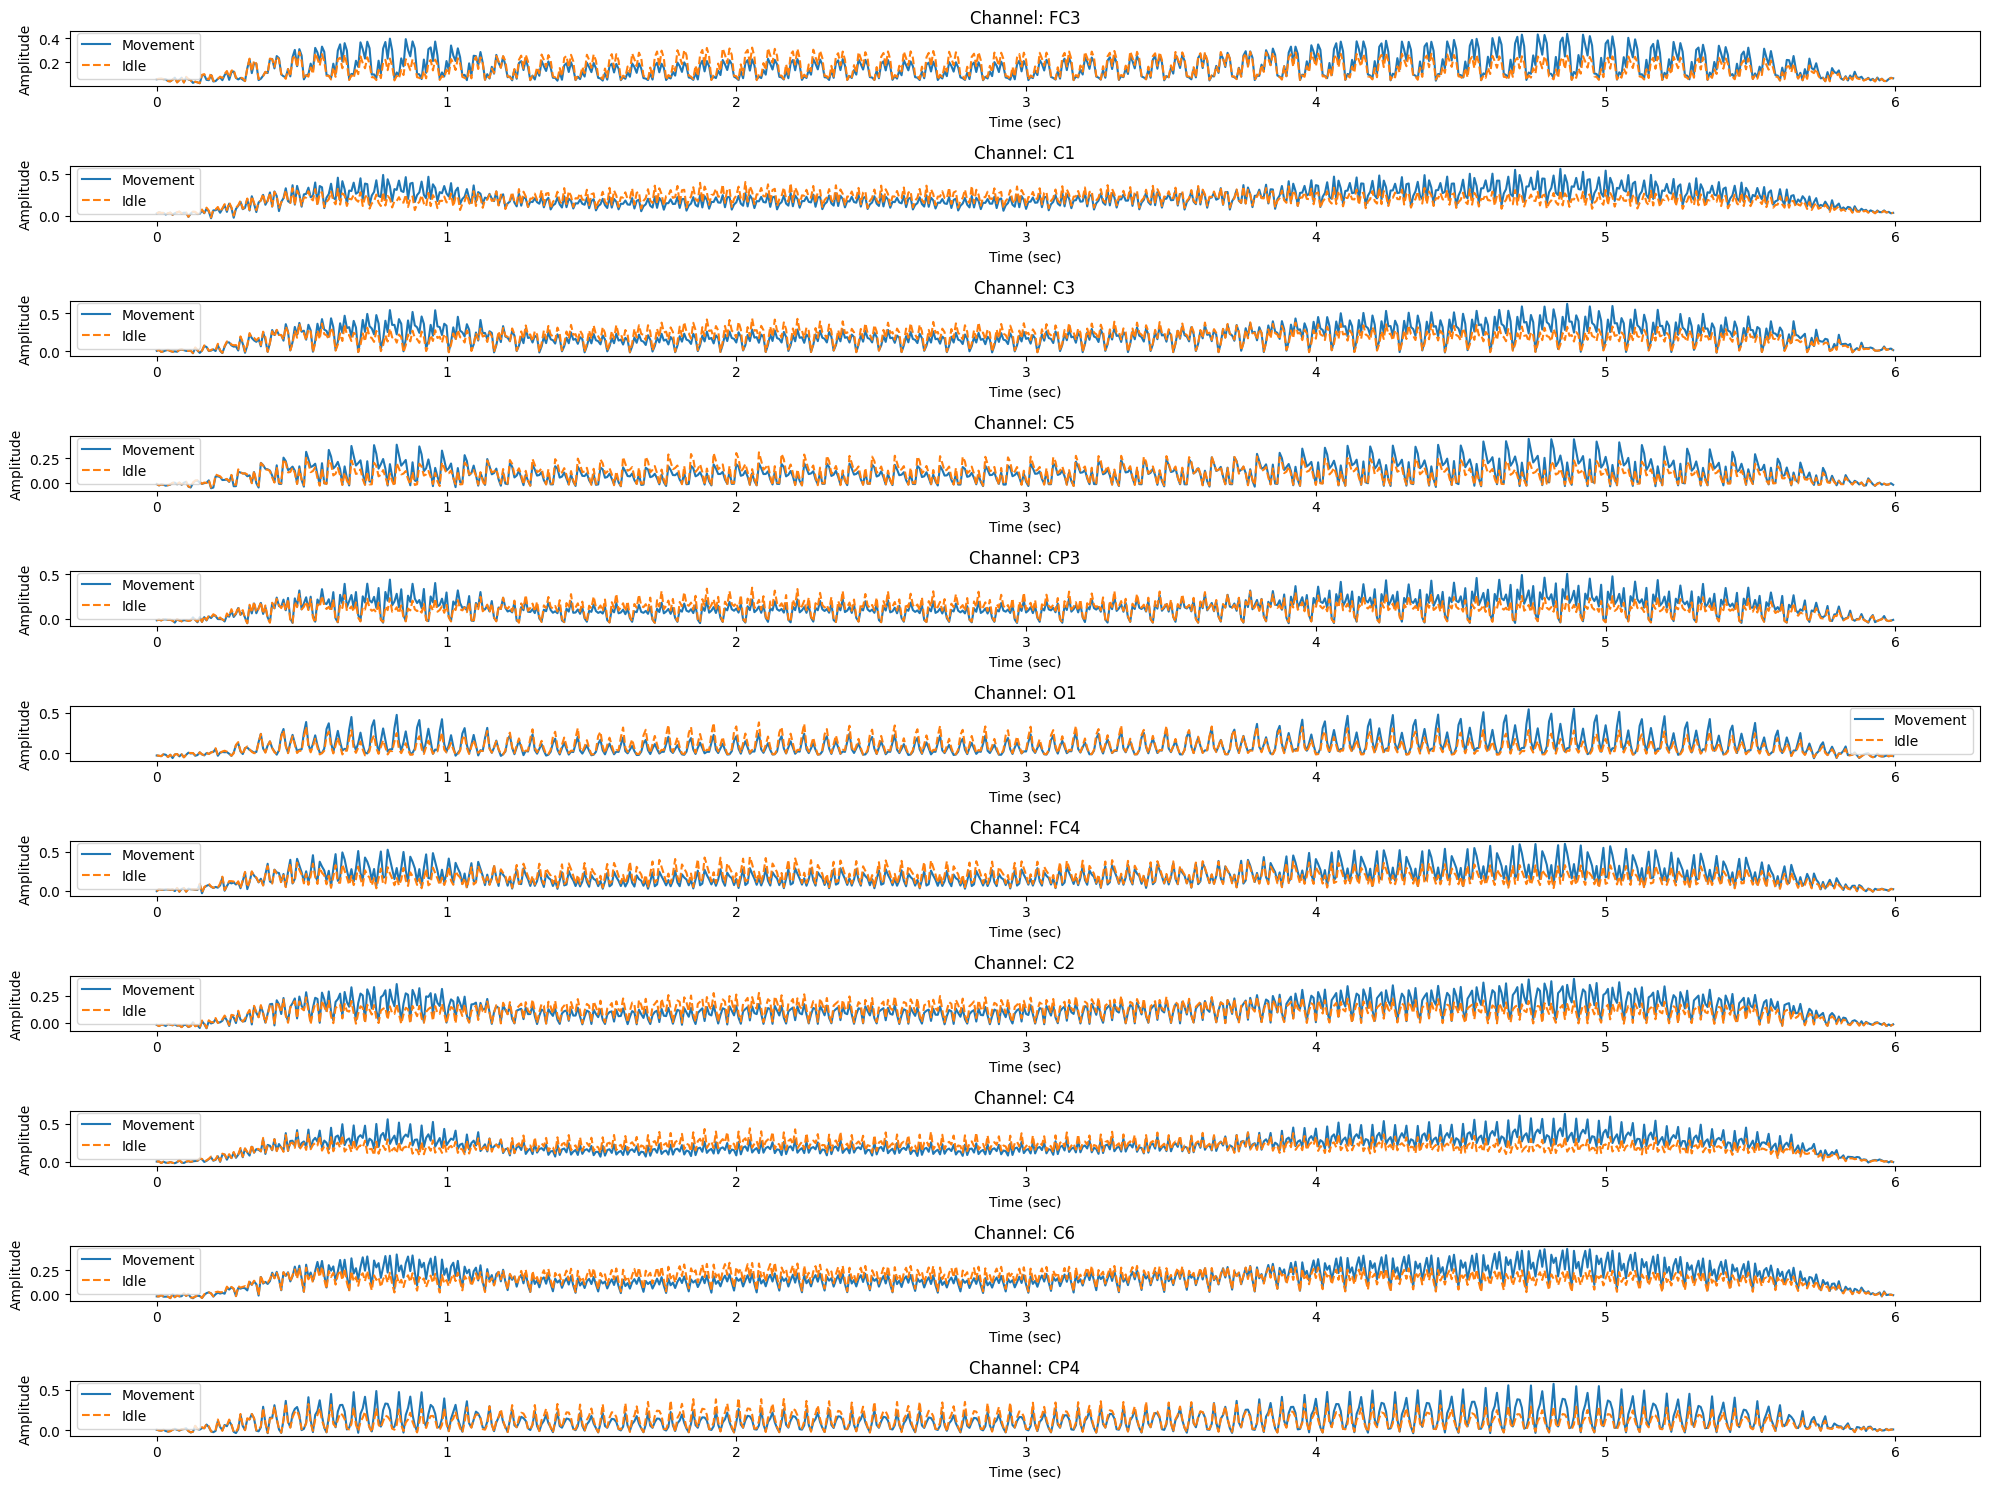

In [15]:
plot_label_distribution(data_30_AE['labels'])
plot_erp(data_30_AE,'segmentedEEG')

### Power spectrum dinesty

In [29]:
def plot_avg_psd_by_electrode_group(eeg_data, eeg_key):
    # Helper function to extract number presence and parity
    def get_number_parity(channel_name):
        numbers = ''.join(filter(str.isdigit, channel_name))
        if not numbers:
            return 'non-numeric'
        elif int(numbers) % 2 == 0:
            return 'even'
        else:
            return 'odd'

    # Initialize dictionaries to store PSDs
    psds = {'even': [], 'odd': [], 'non-numeric': []}

    # Loop over each trial and channel to calculate PSDs
    for trial_idx, trial in enumerate(eeg_data[eeg_key]):
        label = eeg_data['labels'][trial_idx]
        for channel_idx, channel in enumerate(eeg_data['chanLabels']):
            parity = get_number_parity(channel)
            freqs, psd = welch(trial[channel_idx, :], fs=eeg_data['fs'], nperseg=256)
            psds[parity].append((label, psd))

    # Plotting function
    def plot_psd_for_group(group_psd, group_name):
        # Separate movement and idle PSDs
        movement_psds = [psd for label, psd in group_psd if label == 1]
        idle_psds = [psd for label, psd in group_psd if label == 0]

        # Calculate average PSDs
        avg_movement_psd = np.mean(movement_psds, axis=0) if movement_psds else np.zeros_like(freqs)
        avg_idle_psd = np.mean(idle_psds, axis=0) if idle_psds else np.zeros_like(freqs)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.semilogy(freqs, avg_movement_psd, label='Movement')
        plt.semilogy(freqs, avg_idle_psd, label='Idle', linestyle='--')
        plt.title(f'Average PSD for {group_name} Numbered Electrodes')
        plt.xlabel('Frequency (Hz)')
        plt.xlim(right = 40)
        plt.ylabel('Power Spectral Density (dB/Hz)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Plot for each group
    for group_name, psd_data in psds.items():
        if psd_data:  # Check if there are any PSDs to plot
            plot_psd_for_group(psd_data, group_name.capitalize())



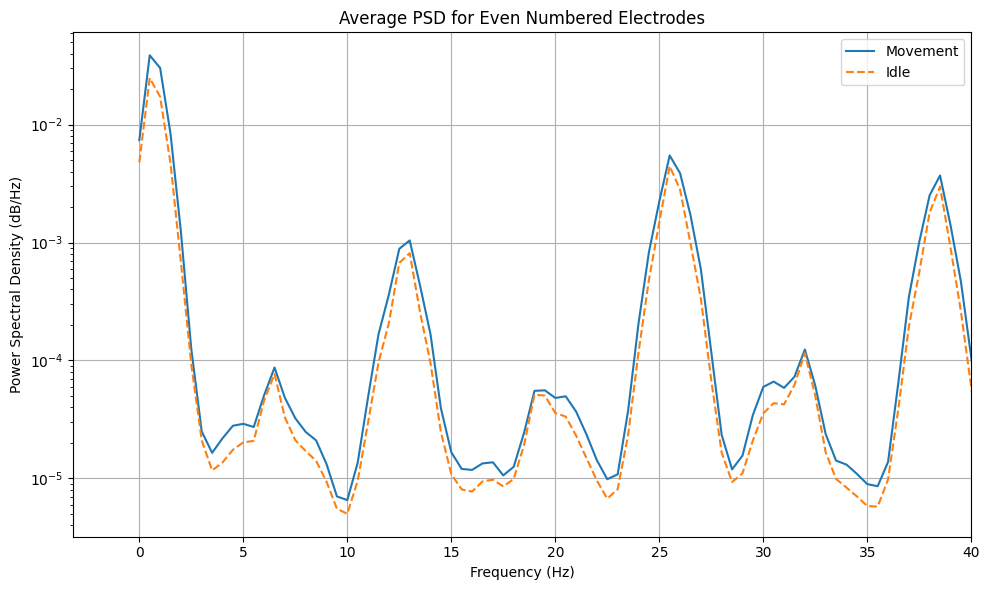

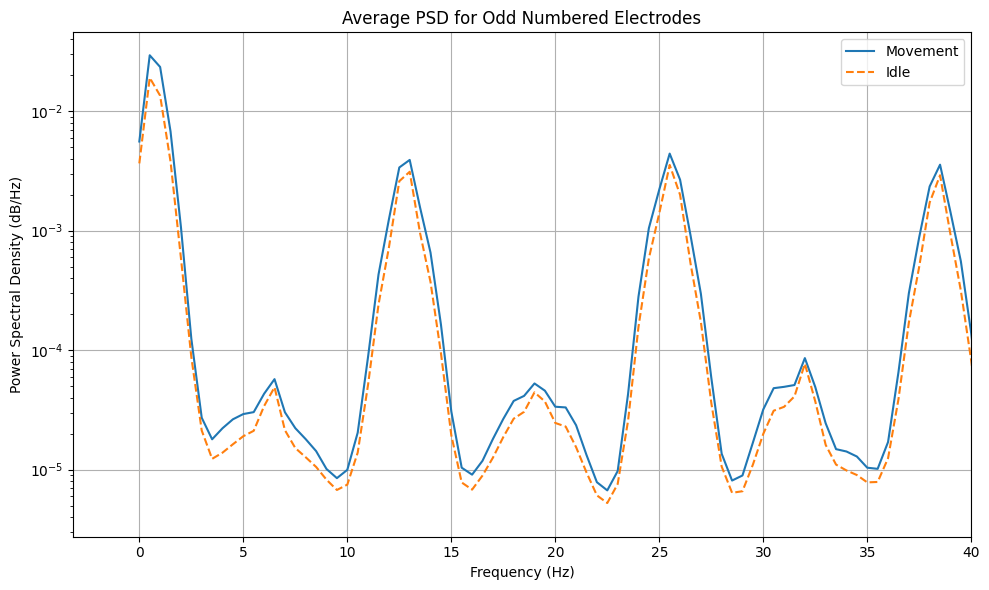

In [30]:
plot_avg_psd_by_electrode_group(data_30_AE, 'segmentedEEG')


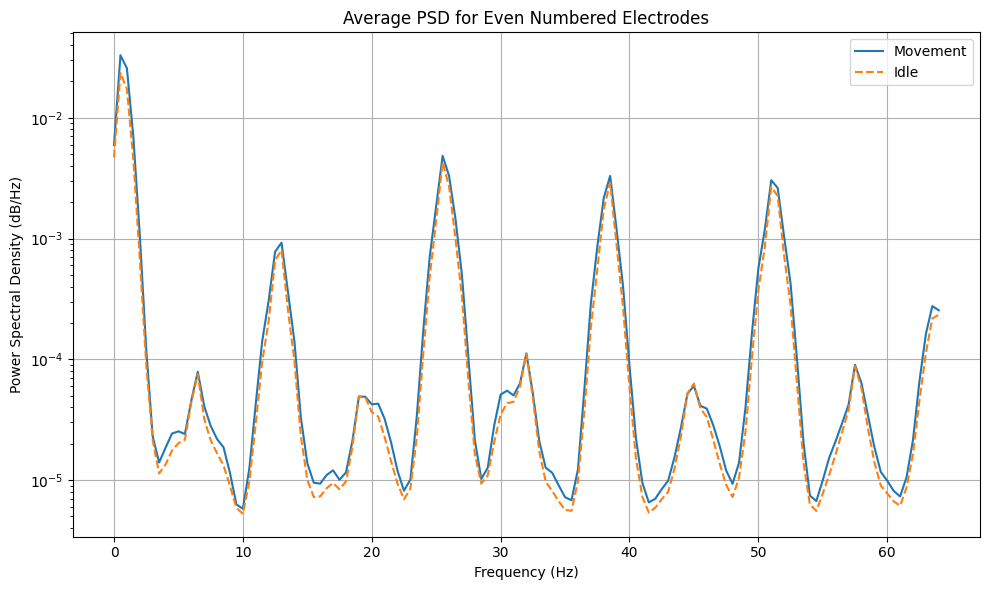

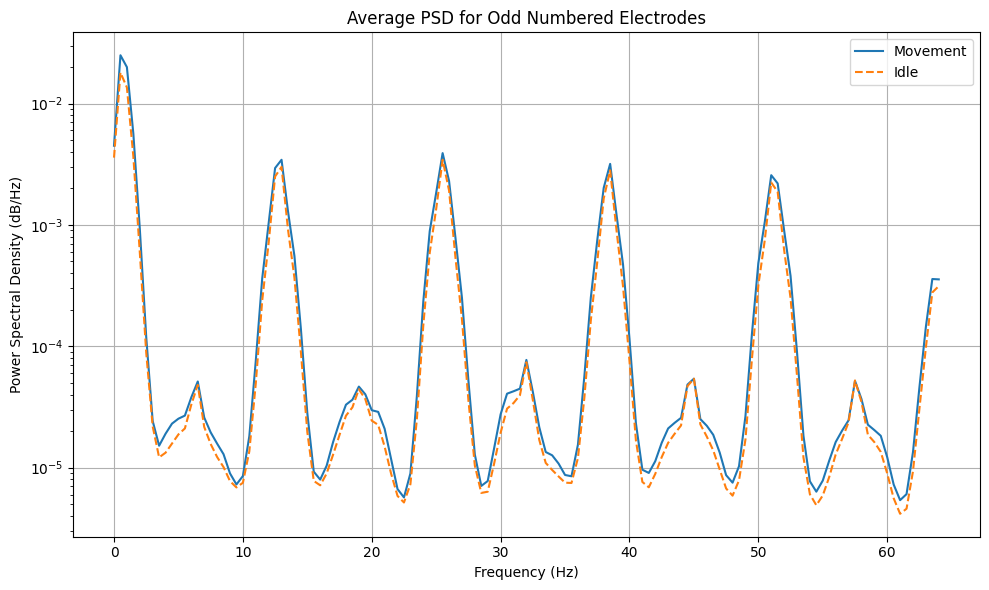

In [11]:
plot_avg_psd_by_electrode_group(data_30_50_AE, 'segmentedEEG')

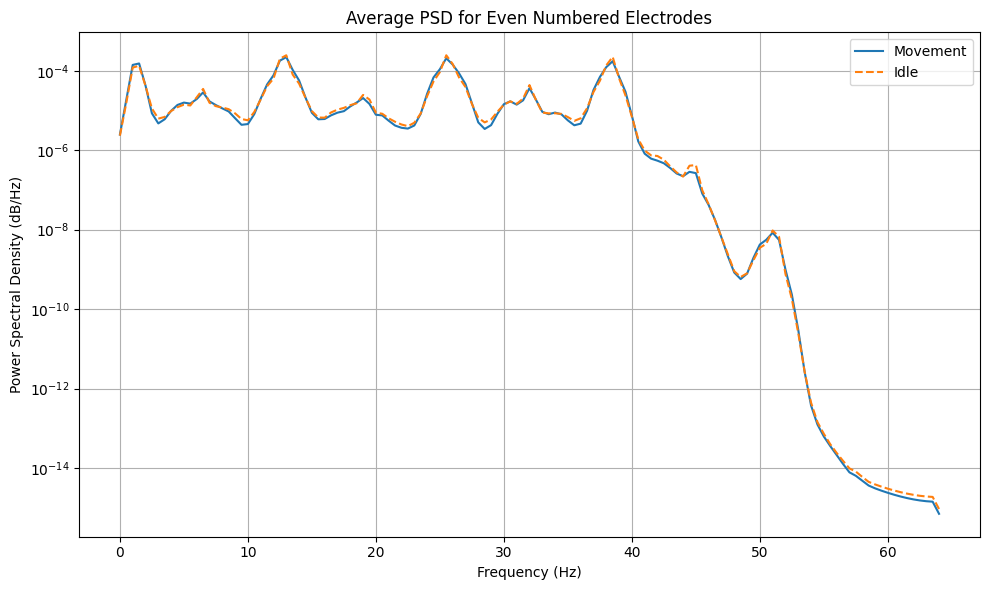

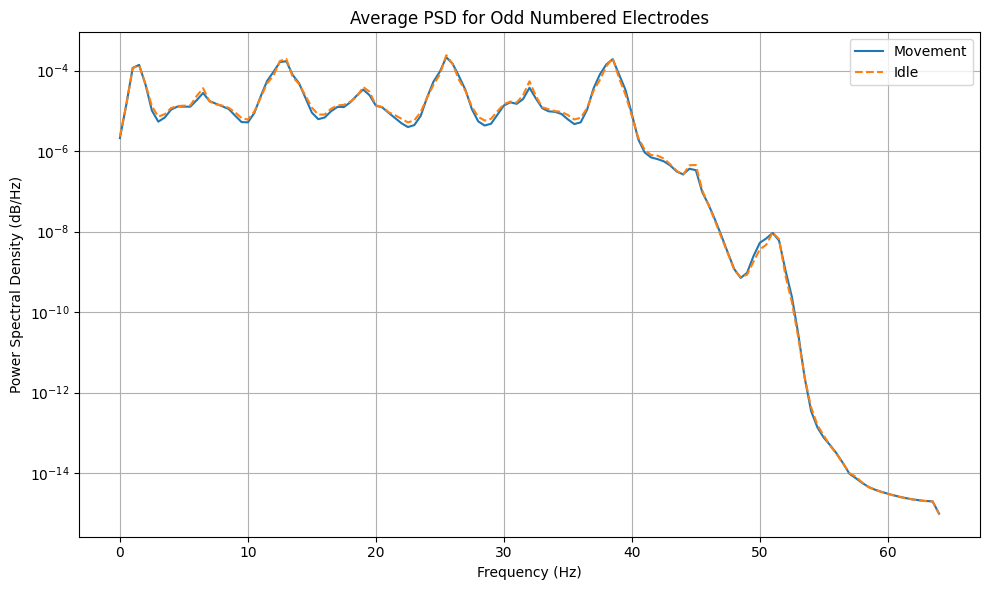

In [47]:
plot_avg_psd_by_electrode_group(data_30_AE,'filtered_data')


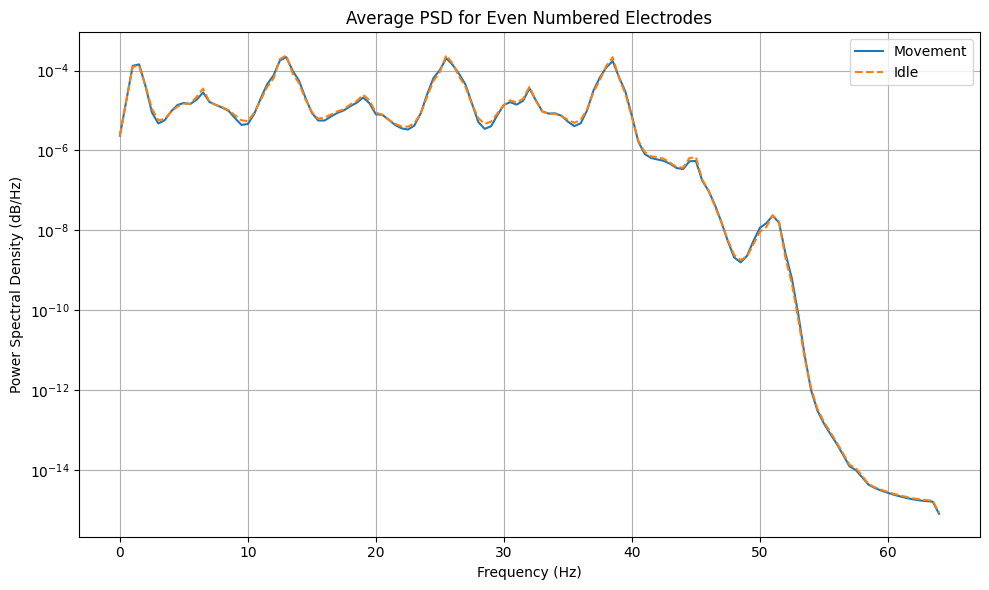

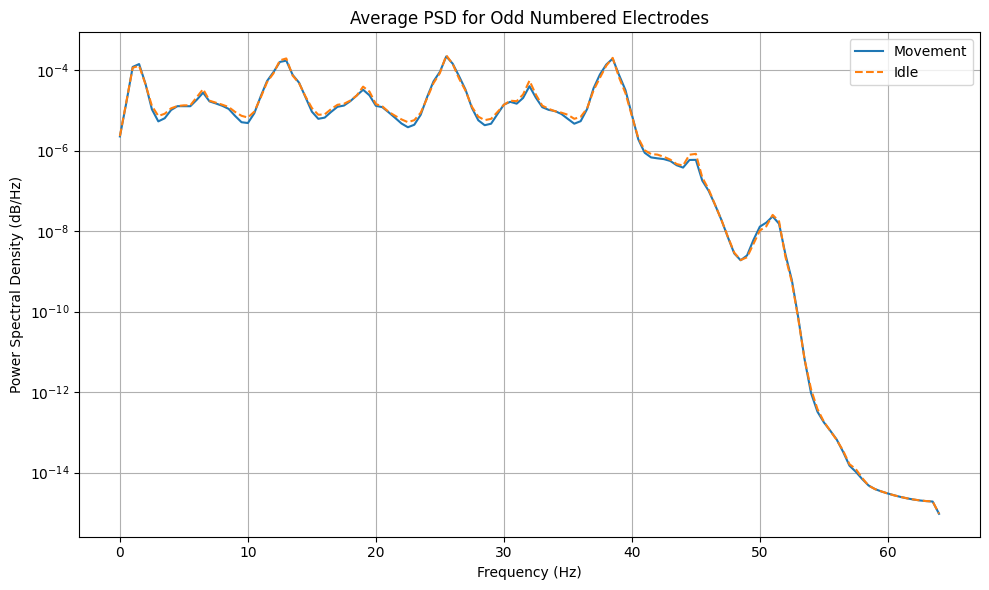

In [12]:
plot_avg_psd_by_electrode_group(data_30_50_AE, 'filtered_data')

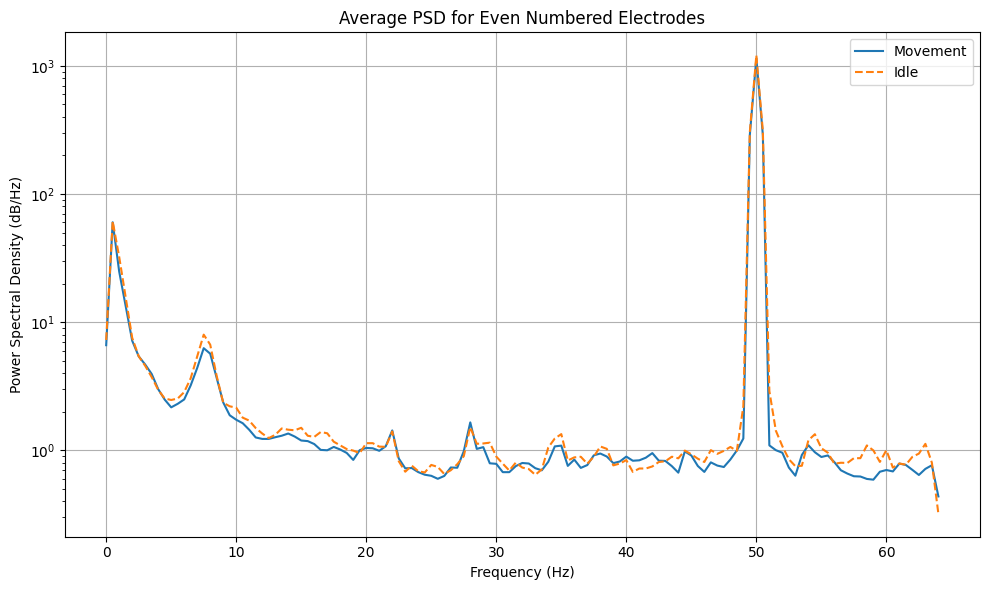

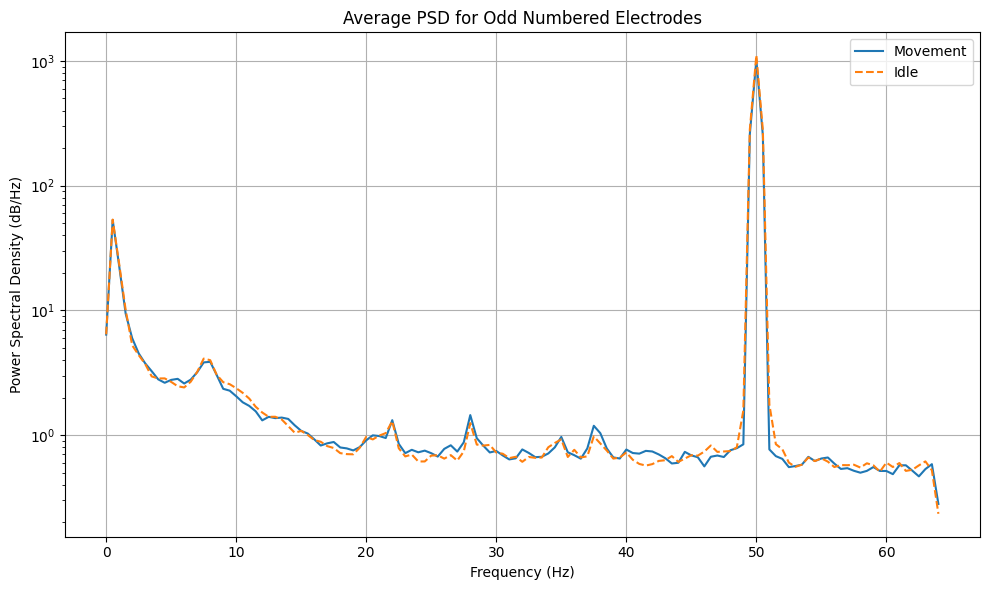

In [18]:
plot_avg_psd_by_electrode_group(data_30,'segmentedEEG')


### Power spectrum dinesty in MNE (sanity check)

In [32]:
# convert data to mne.Raw
ch_names =  data_30_AE['chanLabels']
ch_types = ['eeg'] * len(ch_names)
sfreq =  data_30_AE['fs']

# n_samples = min([t.shape[0] for t in trials])

epochs_array =  data_30_AE['segmentedEEG']

info = mne.create_info(ch_names, sfreq, ch_types)
epochs = mne.EpochsArray(epochs_array, info)

# set montage
montage = make_standard_montage('standard_1020')
epochs.set_montage(montage)

<EpochsArray |  1954 events (all good), 0 – 5.99219 s, baseline off, ~126.0 MB, data loaded,
 '1': 1954>

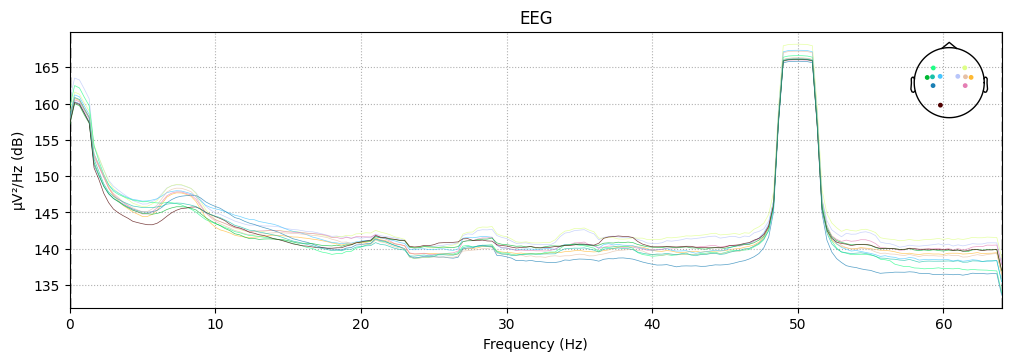

In [90]:
epochs.plot_psd();


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    3.1s
[Parallel(n_job

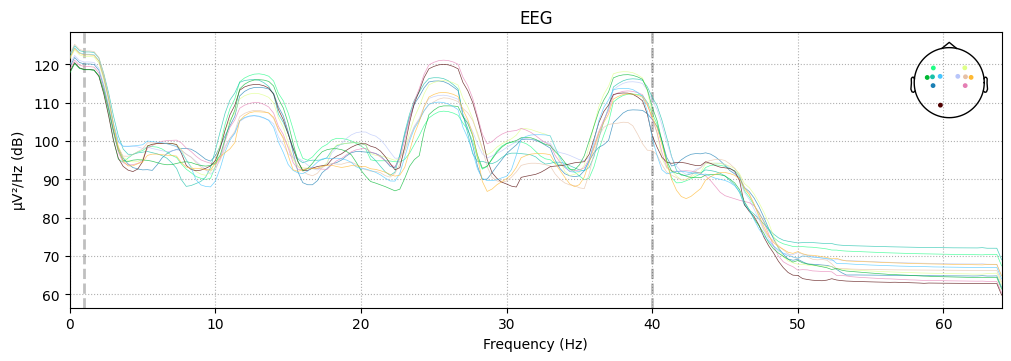

In [34]:
# Apply band-pass filter
epochs.filter(1., 40., fir_design='firwin', skip_by_annotation='edge', verbose=True)

# apply notch filter at 25
#epochs.filter(24, 26, fir_design='firwin', skip_by_annotation='edge')

epochs_train = epochs.copy().crop(tmin=3., tmax=None)
epochs_train.plot_psd();

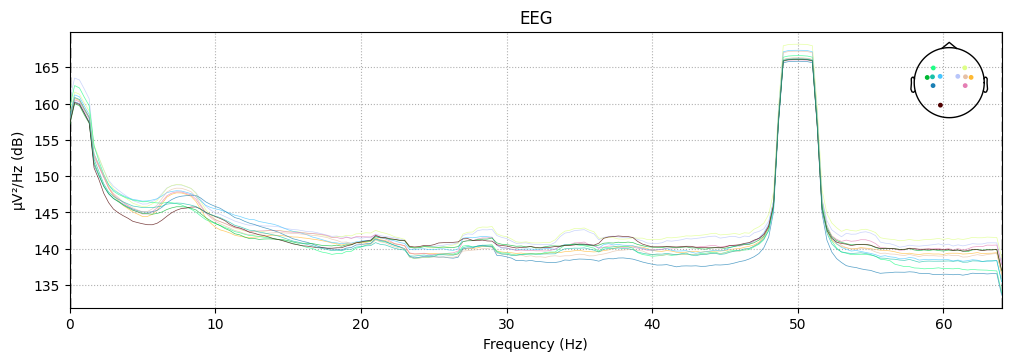

In [52]:
# convert data to mne.Raw
ch_names =  data_30['chanLabels']
ch_types = ['eeg'] * len(ch_names)
sfreq =  data_30['fs']

# n_samples = min([t.shape[0] for t in trials])

epochs_array =  data_30['segmentedEEG']

info = mne.create_info(ch_names, sfreq, ch_types)
epochs = mne.EpochsArray(epochs_array, info)

# set montage
montage = make_standard_montage('standard_1020')
epochs.set_montage(montage)

epochs.plot_psd();



### spectrograms

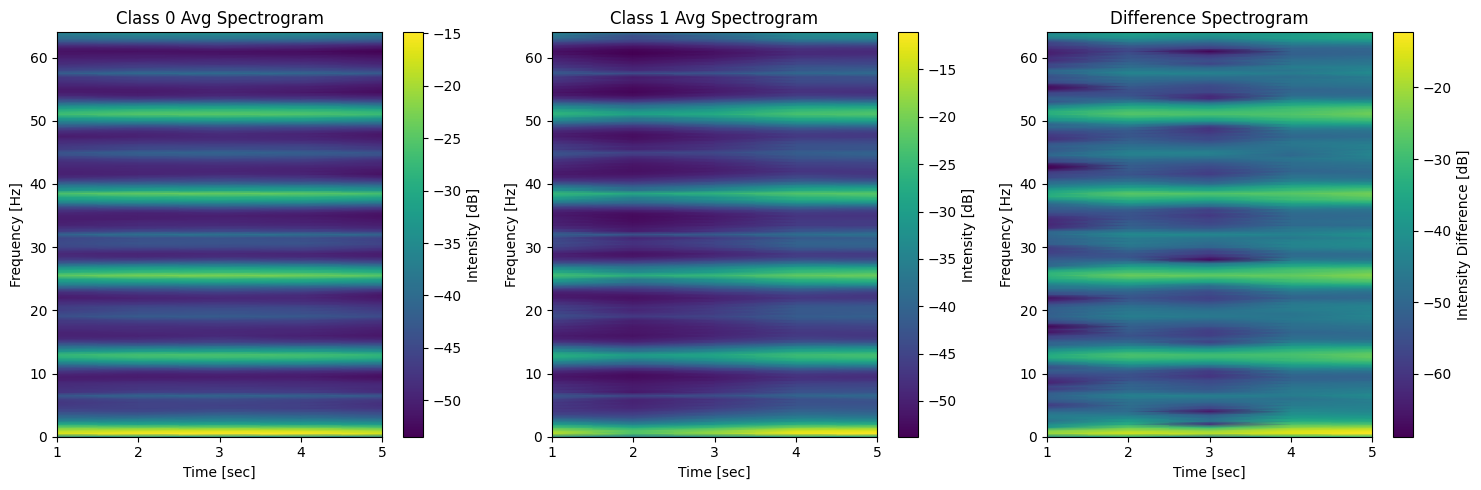

In [10]:
def compute_avg_spectrogram(eeg_data,fs):
    """
    Compute the average spectrogram across all electrodes and trials.
    """
    n_trials, n_electrodes, _ = eeg_data.shape
    avg_spectrograms = []  # Store average spectrogram for each trial

    for trial in eeg_data:
        trial_spectrograms = []

        for electrode in range(n_electrodes):
            f, t, Sxx = spectrogram(trial[electrode], fs=fs, nperseg=256, noverlap=128)
            trial_spectrograms.append(Sxx)

        # Average across electrodes for this trial
        avg_spectrogram = np.mean(trial_spectrograms, axis=0)
        avg_spectrograms.append(avg_spectrogram)

    # Average across trials
    overall_avg_spectrogram = np.mean(avg_spectrograms, axis=0)
    return f, t, overall_avg_spectrogram

def plot_class_spectrograms_and_difference(eeg_data,eeg_key):
    """
    Plot average spectrograms for each class and the difference between them.
    """
    unique_labels = np.unique(eeg_data['labels'])
    spectrograms = {}

    # Compute and store average spectrogram for each class
    for label in unique_labels:
        class_data = eeg_data[eeg_key][eeg_data['labels'] == label, :, :]
        f, t, avg_spectrogram = compute_avg_spectrogram(class_data, eeg_data['fs'])
        spectrograms[label] = avg_spectrogram

    # Plot average spectrograms for each class
    plt.figure(figsize=(15, 5))
    for i, (label, avg_spectrogram) in enumerate(spectrograms.items(), 1):
        plt.subplot(1, len(unique_labels) + 1, i)
        plt.pcolormesh(t, f, 10 * np.log10(avg_spectrogram), shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'Class {label} Avg Spectrogram')
        plt.colorbar(label='Intensity [dB]')

    # Compute and plot the difference between class-specific average spectrograms
    if len(unique_labels) == 2:
        diff_spectrogram = spectrograms[unique_labels[0]] - spectrograms[unique_labels[1]]
        plt.subplot(1, len(unique_labels) + 1, len(unique_labels) + 1)
        plt.pcolormesh(t, f, 10 * np.log10(np.abs(diff_spectrogram)), shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Difference Spectrogram')
        plt.colorbar(label='Intensity Difference [dB]')

    plt.tight_layout()
    plt.show()

# Example usage
plot_class_spectrograms_and_difference(data_30_AE,'segmentedEEG')


### PCA

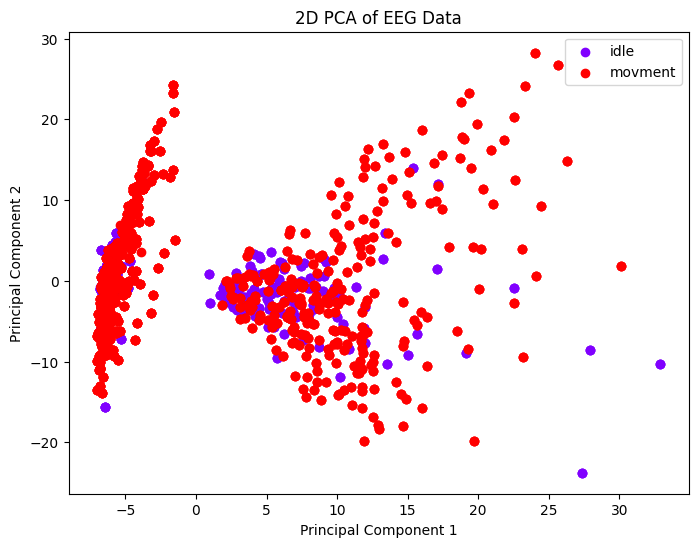

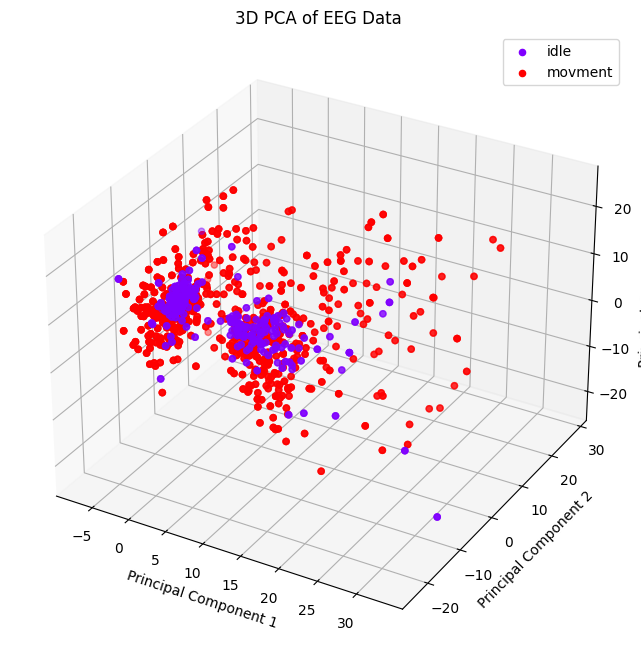

In [60]:
n_trials, n_channels, n_samples = data_30_AE['segmentedEEG'].shape
flattened_data = data_30_AE['segmentedEEG'].reshape(n_trials, n_channels * n_samples)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_data)
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(flattened_data)

unique_labels = np.unique(data_30_AE['labels'])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Plotting 2D PCA
plt.figure(figsize=(8, 6))
for label, color in zip(unique_labels, colors):
    indices = np.where(data_30_AE['labels'] == label)[0]
    if label == 0:
      class_mi = 'idle'
    else:
      class_mi = 'movment'
    plt.scatter(pca_result_3d[indices, 0], pca_result_3d[indices, 1], label=f'{class_mi}', color=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of EEG Data')
plt.legend()
plt.show()

# Plotting 3D PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, color in zip(unique_labels, colors):
    indices = np.where(data_30_AE['labels'] == label)[0]
    if label == 0:
      class_mi = 'idle'
    else:
      class_mi = 'movment'
    ax.scatter(pca_result_3d[indices, 0], pca_result_3d[indices, 1], pca_result_3d[indices, 2], label=f'{class_mi}', color=color)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of EEG Data')
ax.legend()
plt.show()

# Basic classifier

### CSP

In [8]:
def average_covariance(matrices):
    #initialize the sum of covariance matrices
    sum_cov = np.zeros((matrices[0].shape[0], matrices[0].shape[0])) # sum_cov size (CxC)

    #iterate through each matrix and add the covariance matrix to the sum
    for matrix in matrices: # matrix size (CxS)
        #calculate the mean vector of the matrix
        mean_vec = np.mean(matrix, axis=1) # mean_vec size(Cx1)
        #calculate the covariance matrix of the matrix
        # cov_mat = (1/(matrix.shape[0]-1)) * (matrix - mean_vec).T.dot(matrix - mean_vec)
        centered_mat = np.zeros((matrix.shape[0], matrix.shape[1]))
        for row in range(matrix.shape[0]):
          centered_mat[row,:] =  matrix[row,:]  - mean_vec[row] #???
        cov_mat = (centered_mat).dot(centered_mat.T)/np.trace((centered_mat).dot(centered_mat.T))
        #add the covariance matrix to the sum
        sum_cov += cov_mat

    #calculate and return the average covariance matrix
    return sum_cov / len(matrices)


def csp_features(data_dict):
    """
    Compute CSP features.
    data_dict: Data for two classes. Each is shape (trials, channels, samples).
    """

    label0 = np.where(data_dict['labels'] == 0)[0]
    label1 = np.where(data_dict['labels'] == 1)[0]

    # Compute average covariance matrices

    cov1 = average_covariance(data_dict['segmentedEEG'][label0, :,:])
    cov2 =  average_covariance(data_dict['segmentedEEG'][label1,:,:])
    # cov1 = compute_covariance_matrix(X1)
    # cov2 = compute_covariance_matrix(X2)

    # Solve the generalized eigenvalue problem to get the spatial filters
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(cov2).dot(cov1))

    # Sort eigenvalues (and vectors) in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Take the first two and the last two eigenvectors
    W = np.hstack([eigvecs[:, :3], eigvecs[:, -3:]])

    return W

In [9]:
W = csp_features(data_30_AE)

### train LDA model

In [13]:
wcsp = np.array([np.dot(W.T, trial) for trial in data_30_AE['segmentedEEG']])
X = wcsp.reshape(wcsp.shape[0], -1)
y = data_30_AE['labels']

# Split data into training and testing for validation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train LDA
lda = LDA()
lda.fit(X_train, y_train)

# Predict on test set and calculate accuracy
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Training accuracy: {accuracy*100:.2f}%")


Training accuracy: 76.54%


### test

In [14]:
test_data_list = denoised_data_dict[30:-10]
test_accuracies = []

for i in range(len(test_data_list) - 10):
    # Preprocess the data
    test_data = merge_dicts(test_data_list[i:i+10])
    segmentedEEG_test = test_data['segmentedEEG']
    wcsp = np.array([np.dot(W.T, trial) for trial in segmentedEEG_test])
    # features1 = np.log(np.var(wcsp, axis=2))
    X_test = wcsp.reshape(wcsp.shape[0], -1)
    y_test = test_data['labels']

    # Predict and calculate accuracy
    y_pred_test = lda.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    test_accuracies.append(accuracy_test)
    print(f"Test accuracy for days {i+30}-{i+40}: {accuracy_test*100:.2f}%")


Test accuracy for days 30-40: 65.51%
Test accuracy for days 31-41: 65.41%
Test accuracy for days 32-42: 67.67%
Test accuracy for days 33-43: 67.41%
Test accuracy for days 34-44: 68.66%
Test accuracy for days 35-45: 69.85%
Test accuracy for days 36-46: 69.01%
Test accuracy for days 37-47: 69.50%
Test accuracy for days 38-48: 65.47%
Test accuracy for days 39-49: 66.20%
Test accuracy for days 40-50: 68.49%
Test accuracy for days 41-51: 68.00%
Test accuracy for days 42-52: 69.80%
Test accuracy for days 43-53: 70.55%
Test accuracy for days 44-54: 72.41%
Test accuracy for days 45-55: 72.11%
Test accuracy for days 46-56: 75.00%
Test accuracy for days 47-57: 75.18%
Test accuracy for days 48-58: 77.30%
Test accuracy for days 49-59: 79.85%
Test accuracy for days 50-60: 79.85%
Test accuracy for days 51-61: 80.92%
Test accuracy for days 52-62: 77.52%
Test accuracy for days 53-63: 75.56%
Test accuracy for days 54-64: 73.33%
Test accuracy for days 55-65: 73.68%
Test accuracy for days 56-66: 70.90%
T

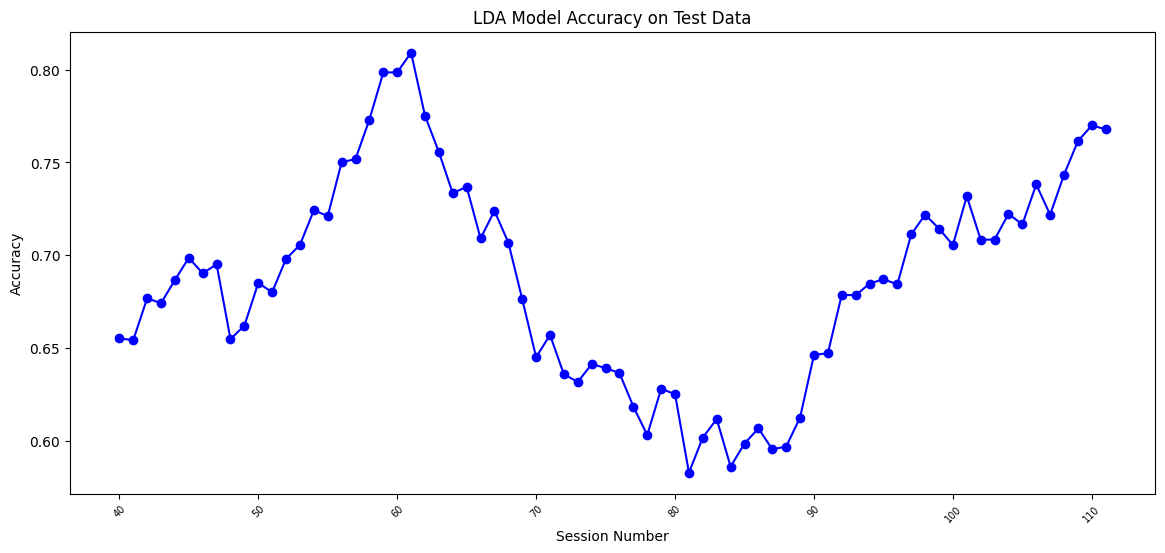

In [15]:
session_numbers = list(range(40, len(test_accuracies) + 40))
# Select every nth label to display (e.g., every 10th day)
n = 10
selected_sessions = session_numbers[::n]
selected_labels = selected_sessions


plt.figure(figsize=(14, 6))
plt.plot(session_numbers, test_accuracies, marker='o', linestyle='-', color='b')
plt.title("LDA Model Accuracy on Test Data")
plt.xlabel("Session Number")
plt.ylabel("Accuracy")
plt.xticks(selected_sessions,selected_labels, rotation=45, fontsize=7)
plt.grid(False)
plt.show()


In [16]:
## use np.log(np.var(wcsp, axis=2)) on the csp featuers

wcsp = np.array([np.dot(W.T, trial) for trial in data_30_AE['segmentedEEG']])
features1 = np.log(np.var(wcsp, axis=2))
X = features1
y = data_30_AE['labels']

# Split data into training and testing for validation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train LDA
lda = LDA()
lda.fit(X_train, y_train)

# Predict on test set and calculate accuracy
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Training accuracy: {accuracy*100:.2f}%")

Training accuracy: 79.01%


In [17]:
test_data_list = denoised_data_dict[30:-10]
test_accuracies_log_csp = []

for i in range(len(test_data_list) - 10):
    # Preprocess the data
    test_data = merge_dicts(test_data_list[i:i+10])
    segmentedEEG_test = test_data['segmentedEEG']
    wcsp = np.array([np.dot(W.T, trial) for trial in segmentedEEG_test])
    features1 = np.log(np.var(wcsp, axis=2))
    X_test = features1
    y_test = test_data['labels']

    # Predict and calculate accuracy
    y_pred_test = lda.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    test_accuracies_log_csp.append(accuracy_test)
    print(f"Test accuracy for days {i+30}-{i+40}: {accuracy_test*100:.2f}%")

Test accuracy for days 30-40: 67.64%
Test accuracy for days 31-41: 67.13%
Test accuracy for days 32-42: 66.88%
Test accuracy for days 33-43: 67.04%
Test accuracy for days 34-44: 67.58%
Test accuracy for days 35-45: 68.04%
Test accuracy for days 36-46: 68.14%
Test accuracy for days 37-47: 68.51%
Test accuracy for days 38-48: 68.98%
Test accuracy for days 39-49: 69.51%
Test accuracy for days 40-50: 70.17%
Test accuracy for days 41-51: 70.84%
Test accuracy for days 42-52: 71.94%
Test accuracy for days 43-53: 72.76%
Test accuracy for days 44-54: 72.83%
Test accuracy for days 45-55: 72.71%
Test accuracy for days 46-56: 72.65%
Test accuracy for days 47-57: 72.23%
Test accuracy for days 48-58: 71.79%
Test accuracy for days 49-59: 71.10%
Test accuracy for days 50-60: 70.01%
Test accuracy for days 51-61: 68.90%
Test accuracy for days 52-62: 67.41%
Test accuracy for days 53-63: 65.91%
Test accuracy for days 54-64: 65.27%
Test accuracy for days 55-65: 64.72%
Test accuracy for days 56-66: 64.13%
T

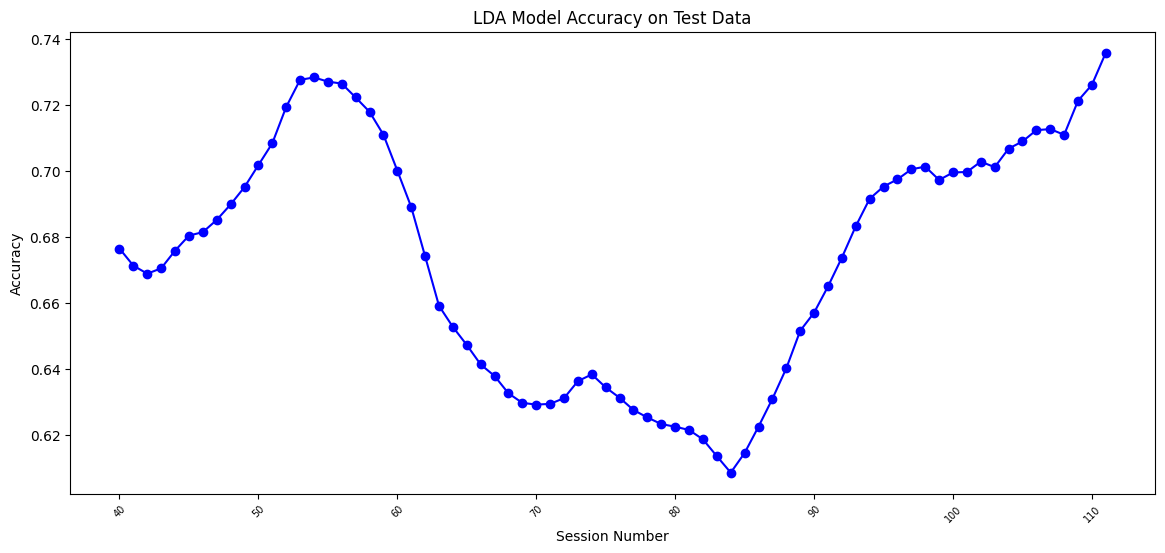

In [18]:
session_numbers = list(range(40, len(test_accuracies_log_csp) + 40))
# Select every nth label to display (e.g., every 10th day)
n = 10
selected_sessions = session_numbers[::n]
selected_labels = selected_sessions


plt.figure(figsize=(14, 6))
plt.plot(session_numbers, test_accuracies_log_csp, marker='o', linestyle='-', color='b')
plt.title("LDA Model Accuracy on Test Data")
plt.xlabel("Session Number")
plt.ylabel("Accuracy")
plt.xticks(selected_sessions,selected_labels, rotation=45, fontsize=7)
plt.grid(False)
plt.show()


# Small world

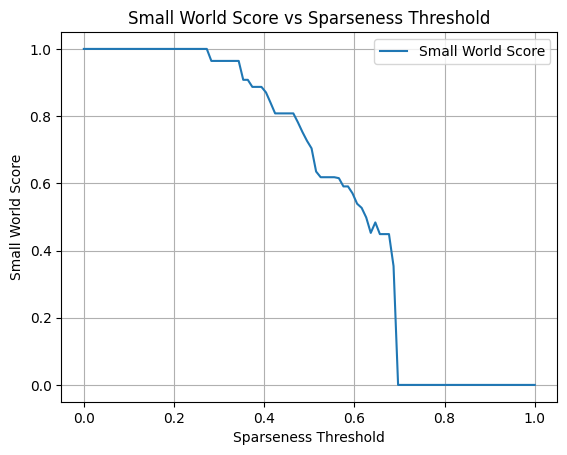

In [10]:
import networkx as nx

def calculate_small_worldness(matrix):
    G = nx.from_numpy_array(matrix)
    cluster_coeff = nx.average_clustering(G)
    try:
        char_path_len = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        char_path_len = np.inf
    small_worldness = cluster_coeff / char_path_len if char_path_len != 0 else 0
    return small_worldness

thresholds = np.linspace(0, 1, 100)  # Adjust as needed
small_world_scores = []

for threshold in thresholds:
  n_trials, n_channels, _ = data_30_AE['segmentedEEG'].shape
  # Initialize an empty array to store individual correlation matrices
  corr_matrices = np.zeros((n_trials, n_channels, n_channels))

  for i in range(n_trials):
      trial_data = data_30_AE['segmentedEEG'][i, :, :]

      # Reshape trial data for correlation calculation: (channels, time)
      # Compute correlation matrix for the trial
      corr_matrix = np.corrcoef(trial_data)

      # Store the computed correlation matrix
      corr_matrices[i] = corr_matrix

  # Calculate the average correlation matrix across all trials
  avg_corr_matrix = np.mean(corr_matrices, axis=0)
  # Threshold the matrix
  sparse_matrix = np.copy(avg_corr_matrix)
  sparse_matrix[sparse_matrix < threshold] = 0
  sws = calculate_small_worldness(sparse_matrix)
  # Calculate small-worldness and append to list
  small_world_scores.append(sws)

# Plotting
plt.plot(thresholds, small_world_scores, label='Small World Score')
plt.xlabel('Sparseness Threshold')
plt.ylabel('Small World Score')
plt.title('Small World Score vs Sparseness Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
(features1.T).shape

(6, 402)

In [11]:
# test_data_list = denoised_data_dict[30:-10]
# thresholds = np.linspace(0.3, 0.6, 5)
# # Create the dictionary
# thresholds_dict_idle = {key: [] for key in thresholds}
# thresholds_dict_mi = {key: [] for key in thresholds}

# for i in range(len(test_data_list) - 10):
#   test_data = merge_dicts(test_data_list[i:i+10])
#   label0 = np.where(test_data['labels'] == 0)[0]
#   label1 = np.where(test_data['labels'] == 1)[0]

#   segmentedEEG_test_idle = test_data['segmentedEEG'][label0, :,:]
#   segmentedEEG_test_mi = test_data['segmentedEEG'][label1,:,:]
#   for th in thresholds:
#     n_trials_idle, n_channels_idle, _ = segmentedEEG_test_idle.shape
#     n_trials_mi, n_channels_mi, _ = segmentedEEG_test_mi.shape
#     corr_matrices_idle = np.zeros((n_trials_idle, n_channels_idle, n_channels_idle))
#     corr_matrices_mi = np.zeros((n_trials_mi, n_channels_mi, n_channels_mi))
#     for i in range(n_trials_idle):
#       trial_data = segmentedEEG_test_idle[i, :, :]
#       corr_matrix = np.corrcoef(trial_data)
#       corr_matrices_idle[i] = corr_matrix
#     # Calculate the average correlation matrix across all trials
#     avg_corr_matrix = np.mean(corr_matrices_idle, axis=0)
#     # Threshold the matrix
#     sparse_matrix = np.copy(avg_corr_matrix)
#     sparse_matrix[sparse_matrix < th] = 0
#     sws = calculate_small_worldness(sparse_matrix)
#     # Calculate small-worldness and append to list
#     thresholds_dict_idle[th].append(sws)
#     for i in range(n_trials_mi):
#       trial_data = segmentedEEG_test_mi[i, :, :]
#       corr_matrix = np.corrcoef(trial_data)
#       corr_matrices_mi[i] = corr_matrix
#     # Calculate the average correlation matrix across all trials
#     avg_corr_matrix = np.mean(corr_matrices_mi, axis=0)
#     # Threshold the matrix
#     sparse_matrix = np.copy(avg_corr_matrix)
#     sparse_matrix[sparse_matrix < th] = 0
#     sws = calculate_small_worldness(sparse_matrix)
#     # Calculate small-worldness and append to list
#     thresholds_dict_mi[th].append(sws)

# with open('/content/gdrive/My Drive/Colab Notebooks/thresholds_dict_idle.pickle', 'wb') as file:
#     pickle.dump(thresholds_dict_idle, file)
# with open('/content/gdrive/My Drive/Colab Notebooks/thresholds_dict_mi.pickle', 'wb') as file:
#     pickle.dump(thresholds_dict_mi, file)


In [15]:
with open('/content/gdrive/My Drive/Colab Notebooks/thresholds_dict_idle.pickle', 'rb') as file:
    thresholds_dict_idle1 = pickle.load(file)
with open('/content/gdrive/My Drive/Colab Notebooks/thresholds_dict_mi.pickle', 'rb') as file:
    thresholds_dict_mi1 = pickle.load(file)

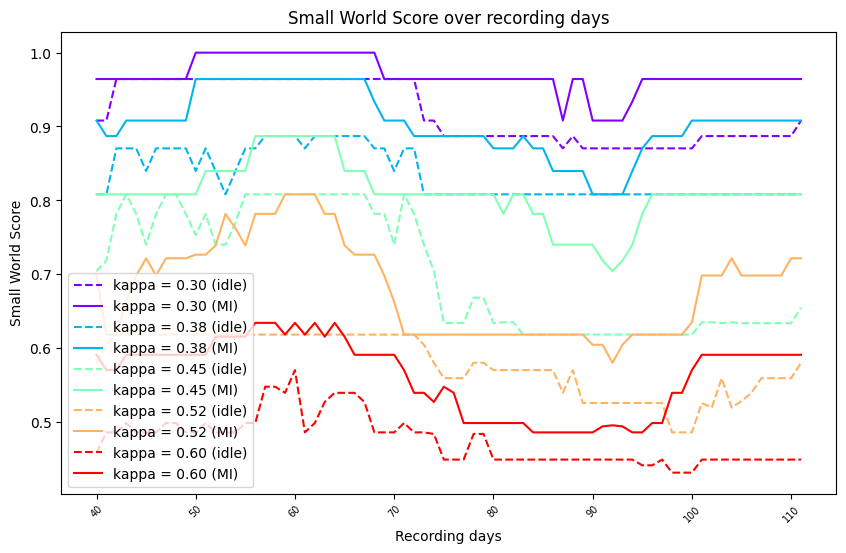

In [22]:
import matplotlib.cm as cm
keys = list(thresholds_dict_idle1.keys())  # Assuming both dicts have the same keys
n = len(keys)
color_map = cm.rainbow(np.linspace(0, 1, n))
colors = {key: color_map[i] for i, key in enumerate(keys)}

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

session_numbers = list(range(40, len(thresholds_dict_idle1[key]) + 40))
# Select every nth label to display (e.g., every 10th day)
n = 10
selected_sessions = session_numbers[::n]
selected_labels = selected_sessions

# Plotting
for key in thresholds_dict_idle1.keys():
    plt.plot(session_numbers, thresholds_dict_idle1[key], '--', label=f'kappa = {key:.2f} (idle)', color=colors[key])
    plt.plot(session_numbers, thresholds_dict_mi1[key], '-', label=f'kappa = {key:.2f} (MI)', color=colors[key])



# Add legend and labels
plt.legend()
plt.title('Small World Score over recording days')
plt.xlabel('Recording days')
plt.ylabel('Small World Score')
plt.xticks(selected_sessions,selected_labels, rotation=45, fontsize=7)
plt.show()



In [23]:
#TDL:

# Connectivity featuers

In [ ]:
import numpy as np
from scipy.signal import hilbert

def cal_phase_synchrony(data,frequency):
    """
    Calculates the phase synchrony between all pairs of electrodes.

    Args:
      data: The EEG data.

    Returns:
      The phase synchrony matrix.
    """

    num_samples, num_electrodes = data.shape
    phase_synchrony = np.zeros((num_samples, num_electrodes))

    # Iterate over all pairs of electrodes
    for i in range(num_electrodes):
        for j in range(i + 1, num_electrodes):
            # Calculate the instantaneous phases of the signals.
            phases_i = np.angle(hilbert(data[:, i]))
            phases_j = np.angle(hilbert(data[:, j]))

            # Calculate the phase differences between the signals.
            phase_differences = phases_i - phases_j

            # Calculate the phase synchrony.
            phase_synchrony[j] = np.mean(np.cos(2 * np.pi * frequency * phase_differences))#, axis=1)
        phase_synchrony[:, i] = np.mean(phase_synchrony)


    # Fill in the lower triangular part of the matrix
    # phase_synchrony += np.transpose(phase_synchrony, axes=(0, 2, 1))

    return phase_synchrony


def calculate_pli(data):
    num_samples, num_electrodes = data.shape
    pli = np.zeros((num_samples, num_electrodes))

    for i in range(num_electrodes):
        for j in range(i+1, num_electrodes):
            # Calculate phase differences
            phase_diff = np.angle(hilbert(data[:, i] - data[:, j]))

            # Calculate signed phase differences
            signed_phase_diff = np.sign(phase_diff)

            # Calculate PLI
            pli[:, i] += signed_phase_diff
            pli[:, j] -= signed_phase_diff  # Symmetric assignment

    pli /= num_electrodes * (num_electrodes - 1) / 2  # Average over electrode pairs

    return pli

def calculate_coh(data):
    num_samples, num_electrodes = data.shape
    coh = np.zeros((num_samples, num_electrodes))

    for i in range(num_electrodes):
        for j in range(i+1, num_electrodes):
            # Calculate magnitude of the correlation coefficients
            abs_coef = np.abs(np.corrcoef(data[:, i], data[:, j])[0, 1])

            # Assign Coherence values
            coh[:, i] += abs_coef
            coh[:, j] += abs_coef  # Symmetric assignment

    coh /= (num_electrodes * (num_electrodes - 1) / 2)  # Average over electrode pairs

    return coh


In [ ]:
import numpy as np
from scipy.signal import hilbert

def cal_phase_synchrony(data,frequency):
    """
    Calculates the phase synchrony between all pairs of electrodes.

    Args:
      data: The EEG data.

    Returns:
      The phase synchrony matrix.
    """

    features_list = []
    num_trials, num_electrodes, num_samples = data.shape
    for t in range(num_trials):
      trail_data = data[t].T
      phase_synchrony = np.zeros((num_samples, num_electrodes))

     # Iterate over all pairs of electrodes
      for i in range(num_electrodes):
          for j in range(i + 1, num_electrodes):
              # Calculate the instantaneous phases of the signals.
              phases_i = np.angle(hilbert(trail_data[:, i]))
              phases_j = np.angle(hilbert(trail_data[:, j]))

              # Calculate the phase differences between the signals.
              phase_differences = phases_i - phases_j

              # Calculate the phase synchrony.
              phase_synchrony[j] = np.mean(np.cos(2 * np.pi * frequency * phase_differences))#, axis=1)
          phase_synchrony[:, i] = np.mean(phase_synchrony)


      # Fill in the lower triangular part of the matrix
      # phase_synchrony += np.transpose(phase_synchrony, axes=(0, 2, 1))
      features_list.append(np.mean(phase_synchrony, axis=0))
    return np.array(features_list)


def calculate_pli(data):
  num_trials, num_electrodes, num_samples = data.shape
  pli_features = np.zeros((num_trials, num_samples, num_electrodes))
  for t in range(num_trials):
    trail_data = data[t].T
    num_samples, num_electrodes = trail_data.shape
    pli = np.zeros((num_samples, num_electrodes))

    for i in range(num_electrodes):
        for j in range(i+1, num_electrodes):
            # Calculate phase differences
            phase_diff = np.angle(hilbert(trail_data[:, i] - trail_data[:, j]))

            # Calculate signed phase differences
            signed_phase_diff = np.sign(phase_diff)

            # Calculate PLI
            pli[:, i] += signed_phase_diff
            pli[:, j] -= signed_phase_diff  # Symmetric assignment

    pli /= num_electrodes * (num_electrodes - 1) / 2  # Average over electrode pairs
    pli_features[i] = pli
    return np.mean(pli_features, axis=1)

def calculate_coh(data):
    num_trials, num_electrodes, num_samples = data.shape
    coh = np.zeros((num_samples, num_electrodes))
    features_list = []
    for t in range(num_trials):
      trail_data = data[t].T
      for i in range(num_electrodes):
          for j in range(i+1, num_electrodes):
              # Calculate magnitude of the correlation coefficients
              abs_coef = np.abs(np.corrcoef(trail_data[:, i], trail_data[:, j])[0, 1])

              # Assign Coherence values
              coh[:, i] += abs_coef
              coh[:, j] += abs_coef  # Symmetric assignment

      coh /= (num_electrodes * (num_electrodes - 1) / 2)  # Average over electrode pairs
      features_list.append(np.mean(coh, axis=0))
    return np.array(features_list)

def calculate_mutual_information_between_features(data):
    """
    Calculate mutual information between pairs of features (channels) in the data.

    Parameters:
    - data: numpy.ndarray of shape (samples, features), containing EEG data.

    Returns:
    - mi_matrix: numpy.ndarray of shape (features, features), mutual information scores between all pairs of features.
    """
    num_trials, num_electrodes, num_samples = data.shape
    mi_matrix = np.zeros((num_electrodes, num_electrodes))
    features_list = []
    for t in range(num_trials):
      trail_data = data[t]
      for i in range(num_electrodes):
          for j in range(i, num_electrodes):
              if i == j:
                  # Mutual information of a feature with itself is maximum (entropy)
                  mi_matrix[i, j] = mutual_info_score(trail_data[:, i], trail_data[:, i])
              else:
                  mi_matrix[i, j] = mutual_info_score(trail_data[:, i], trail_data[:, j])
                  mi_matrix[j, i] = mi_matrix[i, j]  # Symmetric matrix

      mi_matrix /= (num_electrodes * (num_electrodes - 1) / 2)  # Average over electrode pairs
      features_list.append(np.mean(mi_matrix, axis=0))
    return np.array(features_list)

# Graveyard



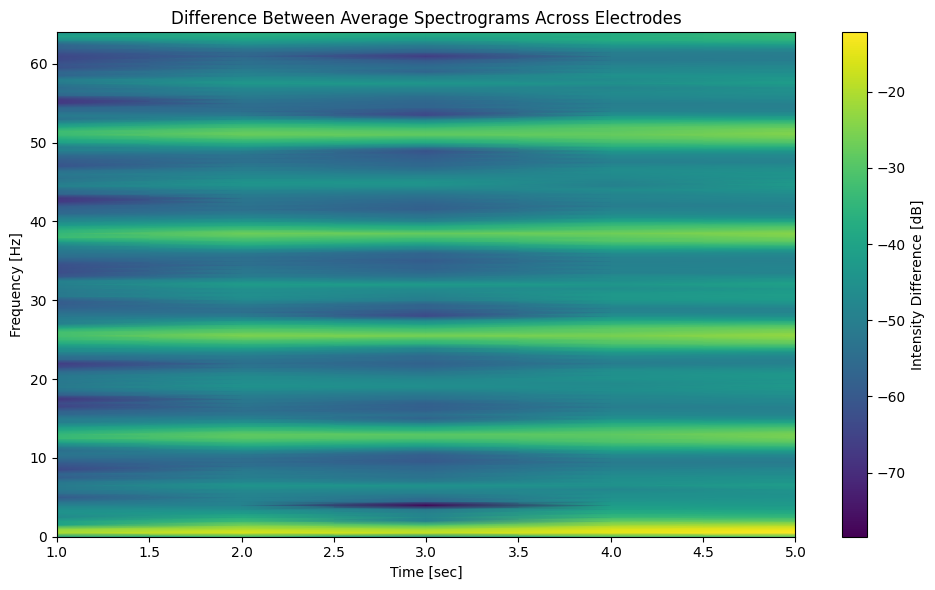

In [ ]:
# def plot_diff_class_spectrograms(eeg_data, labels, fs):
#     """
#     Plots the difference between average spectrograms across all electrodes for two classes in the EEG dataset.

#     Parameters:
#     - eeg_data: 3D numpy array of EEG data with shape (trials, channels, samples).
#     - labels: 1D numpy array of labels corresponding to each trial.
#     - fs: Sampling frequency of the EEG data.
#     """
#     unique_labels = np.unique(labels)
#     class_spectrograms = {}

#     for label in unique_labels:
#         class_trials = eeg_data[labels == label]

#         avg_spectrograms = []
#         for trial in class_trials:
#             spectrogram_accumulator = None

#             for channel_data in trial:
#                 frequencies, times, Sxx = spectrogram(channel_data, fs=fs, nperseg=fs*2, noverlap=fs)
#                 if spectrogram_accumulator is None:
#                     spectrogram_accumulator = np.zeros_like(Sxx)
#                 spectrogram_accumulator += Sxx

#             avg_spectrogram = spectrogram_accumulator / trial.shape[0]
#             avg_spectrograms.append(avg_spectrogram)

#         overall_avg_spectrogram = np.mean(avg_spectrograms, axis=0)
#         class_spectrograms[label] = overall_avg_spectrogram

#     # Assuming there are only two classes for simplicity; adjust as necessary for more classes
#     if len(unique_labels) == 2:
#         labels_list = list(unique_labels)
#         diff_spectrogram = class_spectrograms[labels_list[0]] - class_spectrograms[labels_list[1]]

#         plt.figure(figsize=(10, 6))
#         plt.pcolormesh(times, frequencies, 10 * np.log10(np.abs(diff_spectrogram)), shading='gouraud', cmap='viridis')
#         plt.colorbar(label='Intensity Difference [dB]')
#         plt.ylabel('Frequency [Hz]')
#         plt.xlabel('Time [sec]')
#         plt.title('Difference Between Average Spectrograms Across Electrodes')
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("This function is designed for two classes. Please adjust the function for more classes.")

# # Example usage
# plot_diff_class_spectrograms(data_30_AE['segmentedEEG'], data_30_AE['labels'], data_30_AE['fs'])


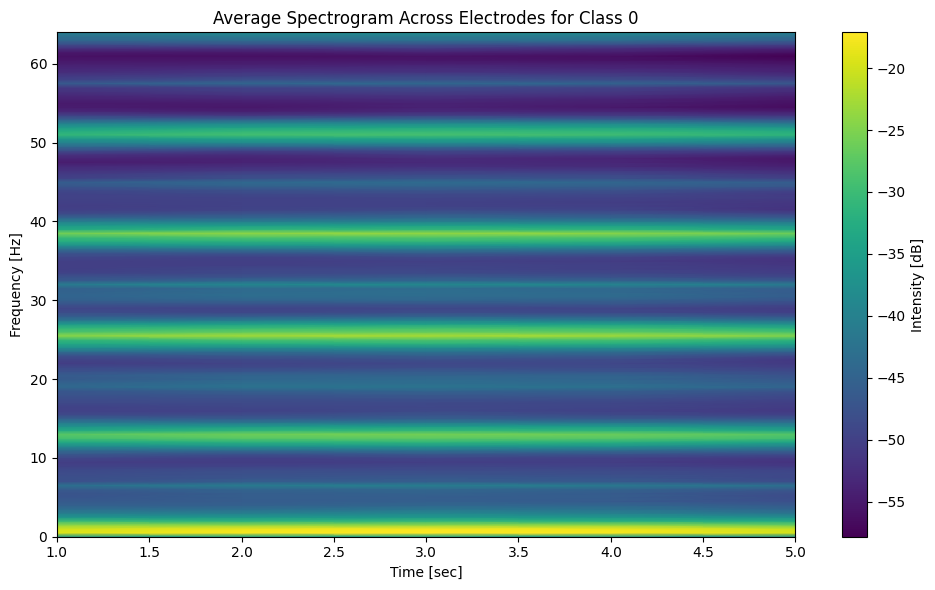

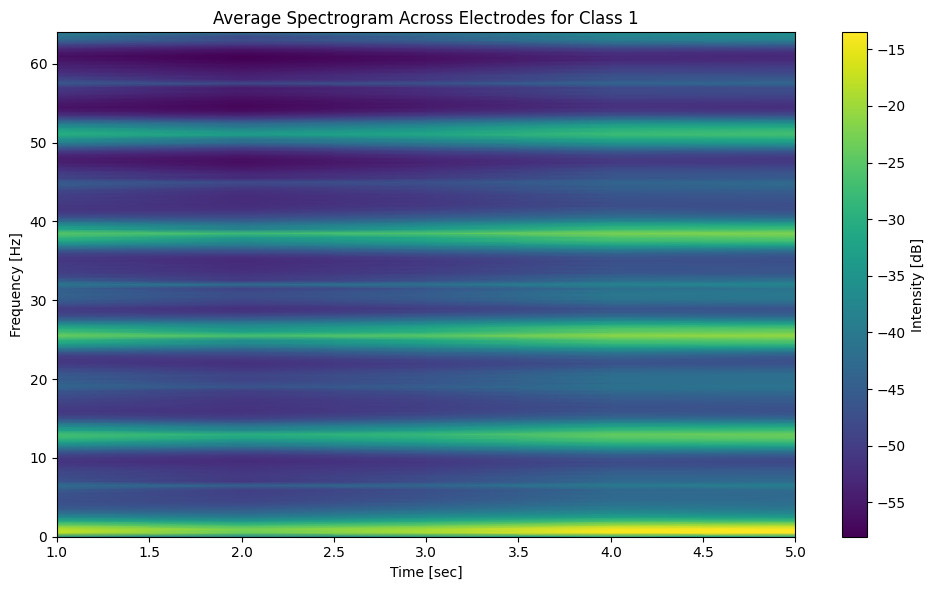

In [54]:
# def plot_avg_class_spectrograms(eeg_data, labels, fs):
#     """
#     Plots average spectrograms across all electrodes for each class in the EEG dataset.

#     Parameters:
#     - eeg_data: 3D numpy array of EEG data with shape (trials, channels, samples).
#     - labels: 1D numpy array of labels corresponding to each trial.
#     - fs: Sampling frequency of the EEG data.
#     """
#     unique_labels = np.unique(labels)

#     for label in unique_labels:
#         class_trials = eeg_data[labels == label]

#         # Initialize list to store average spectrograms for each trial
#         avg_spectrograms = []

#         for trial in class_trials:
#             # Initialize an array to accumulate spectrogram data for each electrode
#             spectrogram_accumulator = None

#             for channel_data in trial:
#                 # Compute the spectrogram for the current electrode
#                 frequencies, times, Sxx = spectrogram(channel_data, fs=fs, nperseg=fs*2, noverlap=fs)

#                 # Initialize the accumulator with the correct shape if it's empty
#                 if spectrogram_accumulator is None:
#                     spectrogram_accumulator = np.zeros_like(Sxx)

#                 # Accumulate the spectrogram data
#                 spectrogram_accumulator += Sxx

#             # Compute the average spectrogram for the current trial across electrodes
#             avg_spectrogram = spectrogram_accumulator / trial.shape[0]
#             avg_spectrograms.append(avg_spectrogram)

#         # Compute the overall average spectrogram across all trials for the current class
#         overall_avg_spectrogram = np.mean(avg_spectrograms, axis=0)

#         plt.figure(figsize=(10, 6))
#         plt.pcolormesh(times, frequencies, 10 * np.log10(overall_avg_spectrogram), shading='gouraud', cmap='viridis')
#         plt.colorbar(label='Intensity [dB]')
#         plt.ylabel('Frequency [Hz]')
#         plt.xlabel('Time [sec]')
#         plt.title(f'Average Spectrogram Across Electrodes for Class {label}')
#         plt.tight_layout()
#         plt.show()

# # Example usage
# plot_avg_class_spectrograms(data_30_AE['segmentedEEG'], data_30_AE['labels'], data_30_AE['fs'])


In [ ]:
# def csp_mat(data_dict):
#   # extract csp
#   #from: Spatial Patterns Underlying Population Differences in the Background EEG


#   label0 = np.where(data_dict['labels'] == 0)[0]
#   label1 = np.where(data_dict['labels'] == 1)[0]

#   # algorithem from Energy Efficiency of Medical Devices and Healthcare Applications
#   # 2020, Pages 25-52

#   C0 = average_covariance(data_dict['segmentedEEG'][label0, :,:])
#   C1 = average_covariance(data_dict['segmentedEEG'][label1,:,:])
#   SIG, U0 = np.linalg.eig(C0+C1)
#   P = np.dot(np.diag(1.0/np.sqrt(SIG)), U0.T)
#   S0 = np.dot(P,np.dot(C0,P.T))
#   S1 = np.dot(P,np.dot(C1,P.T))
#   SIG_S0, U_S0 = np.linalg.eig(S0)
#   SIG_S1, U_S1 = np.linalg.eig(S1)
#   W = np.dot(U_S0.T, P)
#   # W = W[:, [0,1,2,8,9,10]]
#   X_tag = [x/np.trace(np.dot(x, x.T)) for x in data_dict['segmentedEEG']]
#   WX = [np.array(np.dot(W, x)) for x in X_tag]
#   mat_squared = [np.sum(np.square(mat), axis=1)/mat.shape[1] for mat in WX]

#   return(mat_squared)



In [ ]:
# from sklearn.feature_selection import RFE
# dictListStacked_10 = dicts_of_10_days(dictListStacked)
# denoised_data_dict_10 = dicts_of_10_days(denoised_data_dict)


# csp_day_mean_acc = []
# csp_AE_day_mean_acc = []
# ps_day_mean_acc = []
# ps_AE_day_mean_acc = []
# pli_day_mean_acc = []
# pli_AE_day_mean_acc = []
# coh_day_mean_acc = []
# coh_AE_day_mean_acc = []
# all_connectivity_AE_acc = []
# feature_selection_connectivity_AE_acc = []

# lda = LinearDiscriminantAnalysis()
# model = LDA()

# for i in range(0,min(len(dictListStacked_10),len(denoised_data_dict_10))):
#   data_dict = dictListStacked_10[i]
#   data_dict_AE = denoised_data_dict_10[i]
#   # try:
#   mat_squared = csp_mat(data_dict)
#   mat_squared_AE = csp_mat(data_dict_AE)
#   phase_synchrony_mat = cal_phase_synchrony(np.array(mat_squared),dictListStacked[0]['fs'])
#   phase_synchrony_mat_AE = cal_phase_synchrony(np.array(mat_squared_AE),denoised_data_dict[0]['fs'])
#   pli_synchrony_mat =calculate_pli(np.array(mat_squared))
#   pli_synchrony_mat_AE = calculate_pli(np.array(mat_squared_AE))
#   coh_synchrony_mat = calculate_coh(np.array(mat_squared))
#   coh_synchrony_mat_AE = calculate_coh(np.array(mat_squared_AE))
#   all_connectivity_AE = np.concatenate((phase_synchrony_mat_AE, pli_synchrony_mat_AE, coh_synchrony_mat_AE, mat_squared_AE), axis=1)




#   scores_csp = cross_val_score(model, mat_squared, list(data_dict['labels']), cv=2, n_jobs=1)
#   scores_csp_AE = cross_val_score(model, mat_squared_AE, list(data_dict_AE['labels']), cv=2, n_jobs=1)
#   score_phase_synchrony_mat = cross_val_score(model, phase_synchrony_mat, list(data_dict['labels']), cv=2, n_jobs=1)
#   score_phase_synchrony_mat_AE = cross_val_score(model, phase_synchrony_mat_AE, list(data_dict_AE['labels']), cv=2, n_jobs=1)
#   scores_pli = cross_val_score(model, pli_synchrony_mat, list(data_dict['labels']), cv=2, n_jobs=1)
#   scores_pli_AE = cross_val_score(model, pli_synchrony_mat_AE, list(data_dict_AE['labels']), cv=2, n_jobs=1)
#   score_coh_synchrony_mat = cross_val_score(model, coh_synchrony_mat, list(data_dict['labels']), cv=2, n_jobs=1)
#   score_coh_synchrony_mat_AE = cross_val_score(model, coh_synchrony_mat_AE, list(data_dict_AE['labels']), cv=2, n_jobs=1)
#   score_all_connectivity_AE = cross_val_score(model, all_connectivity_AE, list(data_dict_AE['labels']), cv=2, n_jobs=1)

#   lda = LinearDiscriminantAnalysis()
#   rfe = RFE(estimator=lda, n_features_to_select=30)
#   fit = rfe.fit(all_connectivity_AE,  list(data_dict_AE['labels']))
#   feature_selection_connectivity_AE = cross_val_score(model, fit.transform(all_connectivity_AE), list(data_dict_AE['labels']), cv=2, n_jobs=1)

#   csp_day_mean_acc.append(np.mean(scores_csp))
#   csp_AE_day_mean_acc.append(np.mean(scores_csp_AE))
#   ps_day_mean_acc.append(np.mean(score_phase_synchrony_mat))
#   ps_AE_day_mean_acc.append(np.mean(score_phase_synchrony_mat_AE))
#   pli_day_mean_acc.append(np.mean(scores_csp))
#   pli_AE_day_mean_acc.append(np.mean(scores_csp_AE))
#   coh_day_mean_acc.append(np.mean(score_phase_synchrony_mat))
#   coh_AE_day_mean_acc.append(np.mean(score_phase_synchrony_mat_AE))
#   all_connectivity_AE_acc.append(np.mean(score_all_connectivity_AE))
#   feature_selection_connectivity_AE_acc.append(np.mean(feature_selection_connectivity_AE))
#   # except:
#   #   print(f'day {i} didnt worked')
#   #   continue


In [ ]:

# days = [i*10 for i in range(1, len(csp_day_mean_acc) + 1)]

# # Create the plot
# plt.figure(figsize=(10, 6))

# # Plot the accuracy scores from method 1
# plt.plot(days, csp_AE_day_mean_acc, label='AE_csp')

# # Plot the accuracy scores from method 2
# plt.plot(days, all_connectivity_AE_acc, label='all_connectivity_AE')

# # Plot the accuracy scores from method 1
# plt.plot(days, feature_selection_connectivity_AE_acc, label='feature_selection_connectivity_AE')


# # Add titles and labels
# plt.title('Comparison of Accuracy Scores from different Methods')
# plt.xlabel('Day')
# plt.ylabel('Accuracy Score')

# # Add a legend to explain which line corresponds to which method
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# W = csp_features(denoised_data_dict_30days)
# denoised_data_dict_30_50days = merge_dicts(denoised_data_dict[30:50])
# lda = LinearDiscriminantAnalysis()
# model = LDA()

# wcsp = np.array([np.dot(W.T, trial) for trial in denoised_data_dict_30_50days['segmentedEEG']])
# # Create features for classifier (here, log variance of each CSP-filtered channel)
# features1 = np.log(np.var(wcsp, axis=2))
# scores_csp_AE = cross_val_score(model, features1, list(denoised_data_dict_30_50days['labels']), cv=2, n_jobs=1)
# scores_csp_AE

In [ ]:
# print(f'csp score:{np.mean(csp_AE_day_mean_acc)}\nall {np.mean(all_connectivity_AE_acc)}\nfs {np.mean(feature_selection_connectivity_AE_acc)}')

In [ ]:
import numpy as np
from scipy.signal import coherence, hilbert
from urllib.parse import urlencode
import networkx as nx

with open('/content/gdrive/My Drive/Colab Notebooks/denoised_dict_train_size30_OO.pickle', 'rb') as file:
    denoised_data_dict = pickle.load(file)
data_dict = merge_dicts(denoised_data_dict[0:30])
# Extracting values from data_dict
segment_data = data_dict['segmentedEEG']
labels = data_dict['labels']
fs = data_dict['fs']

def compute_pli(trial):
    analytic_signal = hilbert(trial)
    phases = np.angle(analytic_signal)
    pli_matrix = np.zeros((trial.shape[0], trial.shape[0]))
    for i in range(trial.shape[0]):
        for j in range(i+1, trial.shape[0]):
            phase_diff = phases[i] - phases[j]
            pli_matrix[i, j] = np.abs(np.mean(np.sign(np.sin(phase_diff))))
            pli_matrix[j, i] = pli_matrix[i, j]  # Make the matrix symmetric
    return pli_matrix

def threshold_connectivity_matrix(matrix, threshold):
    sparse_matrix = np.copy(matrix)
    sparse_matrix[sparse_matrix < threshold] = 0
    return sparse_matrix

def extract_features(trial, threshold):
    pli_matrix = compute_pli(trial)
    sparse_pli_matrix = threshold_connectivity_matrix(pli_matrix, threshold)

    coh_matrix = np.zeros((trial.shape[0], trial.shape[0]))
    for i in range(trial.shape[0]):
        for j in range(i+1, trial.shape[0]):
            f, Cxy = coherence(trial[i], trial[j], fs=fs)
            coh_matrix[i, j] = np.mean(Cxy)
            coh_matrix[j, i] = coh_matrix[i, j]

    sparse_coh_matrix = threshold_connectivity_matrix(coh_matrix, threshold)

    # Extract the upper triangular parts of the sparse connectivity matrices and concatenate them
    features = np.concatenate((sparse_pli_matrix[np.triu_indices(trial.shape[0], k=1)], sparse_coh_matrix[np.triu_indices(trial.shape[0], k=1)]))

    # Computing Small-worldness:
    # Create a Graph from the sparse_pli_matrix
    G = nx.from_numpy_array(sparse_pli_matrix)  # Ensure this line is corrected

    # Compute the Clustering Coefficient
    cluster_coeff = nx.average_clustering(G)

    # Compute the Characteristic Path Length
    try:
        char_path_len = nx.average_shortest_path_length(G)
    except nx.NetworkXError:  # Handle the case where the graph is not connected
        char_path_len = np.inf

    small_worldness = cluster_coeff / char_path_len if char_path_len != 0 else 0

    # Concatenate small-worldness to features
    features = np.concatenate((features, [small_worldness]))
    return features

X = []
y = []

for idx, trial in enumerate(segment_data):
    threshold = 0.5  # Example threshold
    features = extract_features(trial, threshold)
    X.append(features)
    y.append(labels[idx])  # Assuming labels correspond to the trials in the same order

X = np.array(X)
y = np.array(y)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

# Define the model
model = LinearDiscriminantAnalysis()

# Define the parameter grid
param_grid = {
    'shrinkage': [None, 'auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # Example values, adjust as needed
    'solver': ['svd', 'lsqr', 'eigen']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5)  # 5-fold cross-validation

# Fit the model to your data
grid_search.fit(X, y)

# After fitting, you can find the best parameters as follows:
best_params = grid_search.best_params_
print(f'{best_params}')

{'shrinkage': None, 'solver': 'svd'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 165.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 631, in fit
    self._solve_eigen(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 463, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/usr/local/lib/python3.10/dist-packag

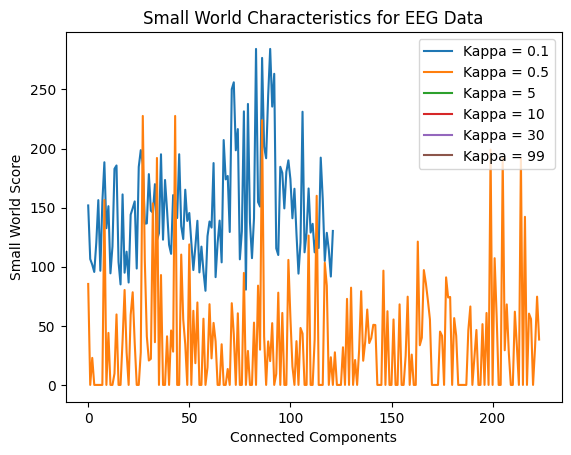

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define a function to calculate small-world characteristics
def calculate_small_world_score(eeg_data, labels, fs, kappa):
    # Calculate correlation matrix
    correlation_matrix = np.corrcoef(eeg_data.reshape(eeg_data.shape[0], -1))

    # Create a binary adjacency matrix based on the correlation matrix and kappa threshold
    adjacency_matrix = (np.abs(correlation_matrix) > kappa).astype(int)

    # Create a list of connected components
    connected_components = list(nx.connected_components(nx.Graph(adjacency_matrix)))

    # Calculate small-world metrics for each connected component
    small_world_scores = []
    for component_nodes in connected_components:
        G = nx.subgraph(nx.Graph(adjacency_matrix), component_nodes)

        try:
            clustering_coefficient = nx.average_clustering(G)
            shortest_path_length = nx.average_shortest_path_length(G)
            small_world_score = (clustering_coefficient / shortest_path_length) / (np.mean(labels) / fs)
            small_world_scores.append(small_world_score)
        except ZeroDivisionError:
            pass

    return small_world_scores

# List of dictionaries containing EEG data
with open('/content/gdrive/My Drive/Colab Notebooks/denoised_dict_train_size30_OO.pickle', 'rb') as file:
    denoised_data_dict = pickle.load(file)

# Kappa thresholds
kappa_values = [0.1, 0.5, 5, 10, 30, 99]

# Initialize lists to store small-world scores
small_world_scores = [[] for _ in kappa_values]

# Loop through EEG data dictionaries
for day_data in denoised_data_dict:
    eeg_data = day_data['segmentedEEG']
    labels = day_data['labels']
    fs = day_data['fs']

    for i, kappa in enumerate(kappa_values):
        small_world_scores_day = calculate_small_world_score(eeg_data, labels, fs, kappa)
        small_world_scores[i].extend(small_world_scores_day)

# Create a graph to visualize small-world scores for different kappa thresholds
for i, kappa in enumerate(kappa_values):
    plt.plot(range(len(small_world_scores[i])), small_world_scores[i], label=f'Kappa = {kappa}')

plt.xlabel('Connected Components')
plt.ylabel('Small World Score')
plt.legend()
plt.title('Small World Characteristics for EEG Data')
plt.show()


In [ ]:
# calculate features for data start from the 30 day (because the AE learned from the first 30 days) exclude the last 10 days so i can test on them at the end
# NOTICE - the score isthe averge fron the 30 dat till the day in the plot!!
# need to add mutual info

from yasa.spectral import bandpower
from sklearn.feature_selection import RFE
from sklearn.metrics import mutual_info_score


with open('/content/gdrive/My Drive/Colab Notebooks/denoised_dict_train_size30_OO.pickle', 'rb') as file:
    denoised_data_dict = pickle.load(file)

shorten_denoised_data = []
for day in denoised_data_dict:
  day['segmentedEEG'] = day['segmentedEEG'][:,:,day['fs']*seconds_to_remove:]
  shorten_denoised_data.append(day)



lda = LinearDiscriminantAnalysis()
model = LDA()
# frequency_bands = [(0.5, 4), (4, 8), (8, 13), (12, 30), (30, 40),(1,40)]
frequency_bands = [ (0.5, 4),(8, 13), (12, 30)]
seconds_to_remove = 4
results = {'csp':[],'all_connectivity_cv':[],'feature_selection':[]}
denoised_data_dict_30['segmentedEEG'] = denoised_data_dict_30['segmentedEEG'][:,:,denoised_data_dict_30['fs']*seconds_to_remove:]
W = csp_features(denoised_data_dict_30) ### NOTICE! change the cal to shorten ver  denoised_data_dict_30['segmentedEEG'] = denoised_data_dict_30['segmentedEEG'][:,:,denoised_data_dict_30['fs']*seconds_to_remove:]

for i in range(40,len(shorten_denoised_data)-20,10): #  -20 becausei might test myself on the last

  all_connectivity = np.array([])
  data_dict = merge_dicts(shorten_denoised_data[30:i])
  # data_dict['segmentedEEG'] = data_dict['segmentedEEG'][:,:,data_dict['fs']*seconds_to_remove:]
  for band in frequency_bands:
    b, a = signal.butter(4, np.array(band)/(data_dict['fs']/2), btype='bandpass')
    filtered_data = signal.filtfilt(b, a, data_dict['segmentedEEG'].T.astype('float')).T
    csp_filtered_data = np.array([np.dot(W.T, trial) for trial in filtered_data])
    bandpower_connectivity = np.concatenate([
        calculate_pli(np.array(filtered_data)),
        cal_phase_synchrony(np.array(filtered_data), data_dict['fs']),
        calculate_coh(np.array(filtered_data)),
        calculate_mutual_information_between_features(np.array(filtered_data)),
        calculate_pli(np.array(csp_filtered_data)),
        cal_phase_synchrony(np.array(csp_filtered_data), data_dict['fs']),
        calculate_coh(np.array(csp_filtered_data)),
        calculate_mutual_information_between_features(np.array(csp_filtered_data))], axis=1)
    if all_connectivity.size == 0:
      all_connectivity = bandpower_connectivity
    else:
      all_connectivity =  np.concatenate([all_connectivity,bandpower_connectivity], axis=1)

  wcsp = np.array([np.dot(W.T, trial) for trial in data_dict['segmentedEEG']])
  # Create features for classifier (here, log variance of each CSP-filtered channel)
  features1 = np.log(np.var(wcsp, axis=2))
  csp_results = cross_val_score(model, features1, list(data_dict['labels']), cv=2, n_jobs=1)
  rfe = RFE(estimator=lda, n_features_to_select=50)
  fit = rfe.fit(all_connectivity,  list(data_dict['labels']))
  feature_selection_connectivity = cross_val_score(model, fit.transform(all_connectivity), list(data_dict['labels']), cv=2, n_jobs=1)
  all_connectivity_cv = cross_val_score(model, all_connectivity, list(data_dict['labels']), cv=2, n_jobs=1)
  results['feature_selection'].append(np.mean(feature_selection_connectivity))
  results['all_connectivity_cv'].append(np.mean(all_connectivity_cv))
  results['csp'].append(np.mean(csp_results))







Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values fo

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/all_connectivity.pickle', 'wb') as file:
    pickle.dump(all_connectivity, file)


Array saved to all_connectivity.pkl


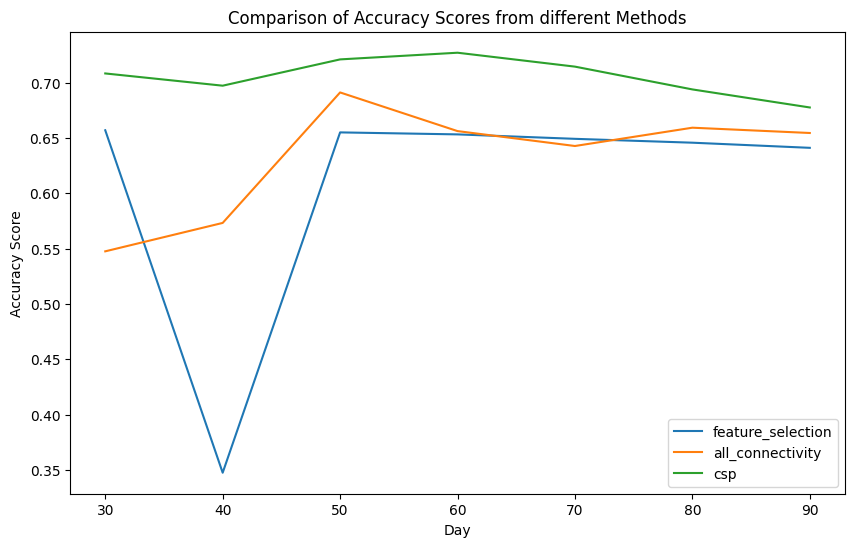

In [ ]:
days = [i*10 for i in range(3, len(results['feature_selection']) + 3)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the accuracy scores from method 1
plt.plot(days,  results['feature_selection'], label='feature_selection')

# Plot the accuracy scores from method 2
plt.plot(days, results['all_connectivity_cv'], label='all_connectivity')

# Plot the accuracy scores from method 1
plt.plot(days, results['csp'], label='csp')


# Add titles and labels
plt.title('Comparison of Accuracy Scores from different Methods')
plt.xlabel('Day')
plt.ylabel('Accuracy Score')

# Add a legend to explain which line corresponds to which method
plt.legend()

# Show the plot
plt.show()

In [ ]:
from yasa.spectral import bandpower
from sklearn.feature_selection import RFE

with open('/content/gdrive/My Drive/Colab Notebooks/denoised_dict_train_size30_OO.pickle', 'rb') as file:
    denoised_data_dict = pickle.load(file)

lda = LinearDiscriminantAnalysis()
model = LDA()
frequency_bands = [(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 40),(1,40)]
results = {'csp':[],'all_connectivity_cv':[],'feature_selection':[]}

for i in range(10,30,10): #  -20 becausei might test myself on the last 2 days

  all_connectivity = np.array([])
  data_dict = merge_dicts(denoised_data_dict[0:i])
  for band in frequency_bands:
    b, a = signal.butter(4, np.array(band)/(data_dict['fs']/2), btype='bandpass')
    filtered_data = signal.filtfilt(b, a, data_dict['segmentedEEG'].T.astype('float')).T
    csp_filtered_data = np.array([np.dot(W.T, trial) for trial in filtered_data])
    bandpower_connectivity = np.concatenate([
        calculate_pli(np.array(filtered_data)),
        cal_phase_synchrony(np.array(filtered_data), data_dict['fs']),
        calculate_coh(np.array(filtered_data)),
        calculate_pli(np.array(csp_filtered_data)),
        cal_phase_synchrony(np.array(csp_filtered_data), data_dict['fs']),
        calculate_coh(np.array(csp_filtered_data))], axis=1)
    if all_connectivity.size == 0:
      all_connectivity = bandpower_connectivity
    else:
      all_connectivity =  np.concatenate([all_connectivity,bandpower_connectivity], axis=1)

  wcsp = np.array([np.dot(W.T, trial) for trial in data_dict['segmentedEEG']])
  # Create features for classifier (here, log variance of each CSP-filtered channel)
  features1 = np.log(np.var(wcsp, axis=2))
  csp_results = cross_val_score(model, features1, list(data_dict['labels']), cv=2, n_jobs=1)
  rfe = RFE(estimator=lda, n_features_to_select=50)
  fit = rfe.fit(all_connectivity,  list(data_dict['labels']))
  feature_selection_connectivity = cross_val_score(model, fit.transform(all_connectivity), list(data_dict['labels']), cv=2, n_jobs=1)
  all_connectivity_cv = cross_val_score(model, all_connectivity, list(data_dict['labels']), cv=2, n_jobs=1)
  results['feature_selection'].append(np.mean(feature_selection_connectivity))
  results['all_connectivity_cv'].append(np.mean(all_connectivity_cv))
  results['csp'].append(np.mean(csp_results))

days = [i*10 for i in range(0, len(results['feature_selection']) )]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the accuracy scores from method 1
plt.plot(days,  results['feature_selection'], label='feature_selection')

# Plot the accuracy scores from method 2
plt.plot(days, results['all_connectivity_cv'], label='all_connectivity')

# Plot the accuracy scores from method 1
plt.plot(days, results['csp'], label='csp')


# Add titles and labels
plt.title('First 30 days')
plt.xlabel('Day')
plt.ylabel('Accuracy Score')

# Add a legend to explain which line corresponds to which method
plt.legend()

# Show the plot
plt.show()



In [ ]:
# ### test on the ten days

# from yasa.spectral import bandpower
# from sklearn.feature_selection import RFE

# with open('/content/gdrive/My Drive/Colab Notebooks/denoised_dict_train_size30_OO.pickle', 'rb') as file:
#     denoised_data_dict = pickle.load(file)

# lda = LinearDiscriminantAnalysis()
# model = LDA()
# frequency_bands = [(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 40),(1,40)]
# results_acc = {'csp':[],'all_connectivity':[],'feature_selection':[]}

# for i in range(40,len(denoised_data_dict)-20,10):

#   all_connectivity = np.array([])
#   all_connectivity_test = np.array([])
#   data_dict_train = merge_dicts(denoised_data_dict[30:i])
#   data_dict_test = merge_dicts(denoised_data_dict[i:i+10])
#   for band in frequency_bands:
#     b, a = signal.butter(4, np.array(band)/(data_dict_train['fs']/2), btype='bandpass')
#     filtered_data_train = signal.filtfilt(b, a, data_dict_train['segmentedEEG'].T.astype('float')).T
#     b, a = signal.butter(4, np.array(band)/(data_dict_test['fs']/2), btype='bandpass')
#     filtered_data_test = signal.filtfilt(b, a, data_dict_test['segmentedEEG'].T.astype('float')).T

#     bandpower_connectivity = np.concatenate([
#         calculate_pli(np.array(filtered_data_train)),
#         cal_phase_synchrony(np.array(filtered_data_train), data_dict_train['fs']),
#         calculate_coh(np.array(filtered_data_train))], axis=1)
#     if all_connectivity.size == 0:
#       all_connectivity = bandpower_connectivity
#     else:
#       all_connectivity =  np.concatenate([all_connectivity,bandpower_connectivity], axis=1)

#     bandpower_connectivity_test = np.concatenate([
#         calculate_pli(np.array(filtered_data_test)),
#         cal_phase_synchrony(np.array(filtered_data_test), data_dict_train['fs']),
#         calculate_coh(np.array(filtered_data_test))], axis=1)
#     if all_connectivity_test.size == 0:
#       all_connectivity_test = bandpower_connectivity_test
#     else:
#       all_connectivity_test =  np.concatenate([all_connectivity_test,bandpower_connectivity_test], axis=1)



#   wcsp = np.array([np.dot(W.T, trial) for trial in data_dict_train['segmentedEEG']])
#   csp_features_train = np.log(np.var(wcsp, axis=2))
#   wcsp = np.array([np.dot(W.T, trial) for trial in data_dict_test['segmentedEEG']])
#   csp_features_test = np.log(np.var(wcsp, axis=2))

#   def acc(X_train, y_train, X_test,y_test):

#     lda.fit(X_train, y_train)
#     y_pred = lda.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     return(accuracy)


#   csp_results = acc(csp_features_train,data_dict_train['labels'],csp_features_test,data_dict_test['labels'])
#   rfe = RFE(estimator=lda, n_features_to_select=50)
#   fit = rfe.fit(all_connectivity,  list(data_dict['labels']))
#   X_train_transformed = fit.transform(all_connectivity)
#   X_test_transformed = fit.transform(all_connectivity_test)
#   feature_selection_connectivity = acc(X_train_transformed,data_dict_train['labels'],X_test_transformed,data_dict_test['labels'])
#   all_connectivity = acc(all_connectivity,data_dict_train['labels'],all_connectivity_test,data_dict_test['labels'])
#   results_acc['feature_selection'].append(feature_selection_connectivity)
#   results_acc['all_connectivity'].append(all_connectivity)
#   results_acc['csp'].append(csp_results)







In [ ]:
len(filtered_data)

375

In [ ]:
def process_data(data_dict, denoised_data_dict, model, frequency_bands):
    results = {}

    for band in frequency_bands:
        # Assume bandpass_filter is a function that isolates the specified frequency band
        # Replace with your actual implementation
        filtered_data = EEG_filter(data_dict, band)
        filtered_denoised_data = EEG_filter(denoised_data_dict, band)

        for label, func in [('csp', csp_mat), ('ps', cal_phase_synchrony), ('pli', calculate_pli), ('coh', calculate_coh)]:

            mat = func(filtered_data)
            mat_AE = func(filtered_denoised_data)

            scores = cross_val_score(model, mat, list(data_dict['labels']), cv=2, n_jobs=1)
            scores_AE = cross_val_score(model, mat_AE, list(denoised_data_dict['labels']), cv=2, n_jobs=1)

            key = f"{label}_{band[0]}-{band[1]}Hz_day_mean_acc"
            results[key] = np.mean(scores)

            key_AE = f"{label}_{band[0]}-{band[1]}Hz_AE_day_mean_acc"
            results[key_AE] = np.mean(scores_AE)

    return results

# Define frequency bands you are interested in
# Format: [(lower_bound, upper_bound), ...]
frequency_bands = [(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 40),(1,40)]

# Initialize accumulators
accumulated_results = {}

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Main Loop
for data_dict, denoised_data in zip(dictListStacked, denoised_data_dict):
    day_results = process_data(data_dict, denoised_data, lda, frequency_bands)

    for key, value in day_results.items():
        if key not in accumulated_results:
            accumulated_results[key] = []
        accumulated_results[key].append(value)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


ValueError: Found array with dim 3. FastICA expected <= 2.

In [ ]:
frequency_bands[0][1]
b, a = signal.butter(4, np.array([frequency_bands[0][0],frequency_bands[0][1]])/(interData['fs']/2), btype='bandpass')

In [ ]:
all_connectivity_AE = np.concatenate([v for k, v in accumulated_results.items() if 'av' in k], axis=1)
# all_connectivity_AE = np.concatenate((phase_synchrony_mat_AE, pli_synchrony_mat_AE, coh_synchrony_mat_AE, mat_squared_AE), axis=1)


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize your LDA models
lda = LinearDiscriminantAnalysis()

def process_data(data_dict, denoised_data_dict, model):
    results = {}
    for label, func in [('csp', csp_mat), ('ps', cal_phase_synchrony), ('pli', calculate_pli), ('coh', calculate_coh)]:
        mat = func(data_dict)
        mat_AE = func(denoised_data_dict)
        scores = cross_val_score(model, mat, list(data_dict['labels']), cv=2, n_jobs=1)
        scores_AE = cross_val_score(model, mat_AE, list(denoised_data_dict['labels']), cv=2, n_jobs=1)

        results[f"{label}_day_mean_acc"] = np.mean(scores)
        results[f"{label}_AE_day_mean_acc"] = np.mean(scores_AE)

    all_connectivity_AE = np.concatenate([
        cal_phase_synchrony(np.array(csp_mat(denoised_data_dict)), denoised_data_dict[0]['fs']),
        calculate_pli(np.array(csp_mat(denoised_data_dict))),
        calculate_coh(np.array(csp_mat(denoised_data_dict))),
        cal_phase_synchrony(np.array(denoised_data_dict), denoised_data_dict[0]['fs']),
        calculate_pli(np.array(denoised_data_dict)),
        calculate_coh(np.array(denoised_data_dict)),
        csp_mat(denoised_data_dict)
    ], axis=1)

    scores_all = cross_val_score(model, all_connectivity_AE, list(denoised_data_dict['labels']), cv=2, n_jobs=1)
    results["all_connectivity_AE_acc"] = np.mean(scores_all)

    rfe = RFE(estimator=lda, n_features_to_select=30)
    fit = rfe.fit(all_connectivity_AE, list(denoised_data_dict['labels']))
    scores_rfe = cross_val_score(model, fit.transform(all_connectivity_AE), list(denoised_data_dict['labels']), cv=2, n_jobs=1)
    results["feature_selection_connectivity_AE_acc"] = np.mean(scores_rfe)

    return results

# Initialize accumulators
accumulated_results = {
    "csp_day_mean_acc": [],
    "csp_AE_day_mean_acc": [],
    "ps_day_mean_acc": [],
    "ps_AE_day_mean_acc": [],
    "pli_day_mean_acc": [],
    "pli_AE_day_mean_acc": [],
    "coh_day_mean_acc": [],
    "coh_AE_day_mean_acc": [],
    "all_connectivity_AE_acc": [],
    "feature_selection_connectivity_AE_acc": []
}

# Main Loop
for data_dict, denoised_data_dict in zip(dictListStacked, denoised_data_dict):
    day_results = process_data(data_dict, denoised_data_dict, lda)

    for key, value in day_results.items():
        accumulated_results[key].append(value)





In [ ]:
import matplotlib.pyplot as plt

# List of days (assuming the length of both method1_scores and method2_scores is 5)
days = [i for i in range(1, len(csp_day_mean_acc) + 1)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the accuracy scores from method 1
plt.plot(days, csp_day_mean_acc, label='csp')

# Plot the accuracy scores from method 2
plt.plot(days, csp_AE_day_mean_acc, label='AE_csp')

# Plot the accuracy scores from method 1
plt.plot(days, ps_day_mean_acc, label='ps_day_mean_acc')

# Plot the accuracy scores from method 2
plt.plot(days, ps_AE_day_mean_acc, label='ps_AE_day_mean_acc')

# Plot the accuracy scores from method 1
plt.plot(days, pli_day_mean_acc, label='csp')

# Plot the accuracy scores from method 2
plt.plot(days, pli_AE_day_mean_acc, label='AE_csp')

# Plot the accuracy scores from method 1
plt.plot(days, coh_day_mean_acc, label='ps_day_mean_acc')

# Plot the accuracy scores from method 2
plt.plot(days, coh_AE_day_mean_acc, label='ps_AE_day_mean_acc')

# Add titles and labels
plt.title('Comparison of Accuracy Scores from different Methods')
plt.xlabel('Day')
plt.ylabel('Accuracy Score')

# Add a legend to explain which line corresponds to which method
plt.legend()

# Show the plot
plt.show()


In [ ]:
csp_day_mean_acc

In [ ]:
# Create RFE model and select 3 attributes
rfe = RFE(lda, 3)
fit = rfe.fit(X_train, y_train)

# Print selected features
print("Num Features:", fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

In [ ]:
def phase_synchrony(data):
  """
  Calculates the phase synchrony between all pairs of electrodes.

  Args:
    data: The EEG data.

  Returns:
    The phase synchrony matrix.
  """

  # Calculate the instantaneous phases of the signals.
  phases = np.angle(hilbert(data))

  # Calculate the phase differences between the signals.
  phase_differences = phases[:, np.newaxis] - phases

  # Calculate the phase synchrony.
  phase_synchrony = np.mean(np.cos(2 * np.pi * frequency * phase_differences), axis=1)

  return phase_synchrony


In [ ]:
def imaginary_part_of_coherency(data):
  """
  Calculates the imaginary part of coherency between all pairs of electrodes.

  Args:
    data: The EEG data.

  Returns:
    The imaginary part of coherency matrix.
  """

  # Calculate the coherence.
  coherence = coherency(data)

  # Calculate the imaginary part of the coherence.
  imaginary_part_of_coherence = np.imag(coherence)

  return imaginary_part_of_coherence

def coherency(data):
  """
  Calculates the coherence between all pairs of electrodes.

  Args:
    data: The EEG data.

  Returns:
    The coherence matrix.
  """

  # Calculate the spectrogram of the data.
  spectrogram = np.abs(np.fft.fft(data))

  # Calculate the coherence.
  coherence = np.mean(spectrogram[:, :, np.newaxis] * spectrogram[:, np.newaxis, :], axis=2)

  return coherence

In [ ]:
import numpy as np
from scipy.signal import hilbert
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

phase_synchrony  = phase_synchrony(data)



In [ ]:
imaginary_part_of_coherency = imaginary_part_of_coherency(data)

[Comparing PLI, wPLI, and dPLI](https://mne.tools/mne-connectivity/stable/auto_examples/dpli_wpli_pli.html)



**small world **

[small world](https://www-nature-com.ezproxy.bgu.ac.il/articles/srep22057)
[small world2](https://academic-oup-com.ezproxy.bgu.ac.il/cercor/article/17/1/92/283419?login=false)

In [ ]:
def build_nx_graph_not_directed(band_ind, channels, data, nodes):
    band_graph = nx.Graph()
    band_graph.add_nodes_from(nodes)
    edg_list = []
    edge_strength = []
    edge_strength_dict = {}
    for i in range(len(channels)):
        for j in range(i + 1, len(channels)):
            edg_list.append((channels[j], channels[i], {'weight': data[j, i, band_ind]}))
            edge_strength.append(data[j, i, band_ind])
            edge_strength_dict[f"{channels[j]}-{channels[i]}"] = data[j, i, band_ind]
    return band_graph, edg_list, edge_strength, edge_strength_dict



In [ ]:

import networkx as nx


#calculate the mean vector of the matrix
mean_vec = np.mean(data[0], axis=1) # mean_vec size(Cx1)
#calculate the covariance matrix of the matrix
# cov_mat = (1/(matrix.shape[0]-1)) * (matrix - mean_vec).T.dot(matrix - mean_vec)
centered_mat = np.zeros((data[0].shape[0], data[0].shape[1]))
for row in range(data[0].shape[0]):
  centered_mat[row,:] =  data[0][row,:] #- mean_vec[row] ???
cov_mat = (centered_mat).dot(centered_mat.T)/np.trace((centered_mat).dot(centered_mat.T))

# Construct graph from data
G = nx.from_numpy_array(cov_mat)

# Set threshold for small-world connections
threshold = 1

# Iterate over nodes
for node1 in G.nodes():
    for node2 in G.nodes():
        # Calculate degree of separation
        dist = nx.shortest_path_length(G, node1, node2)

        # Check if within threshold
        if dist <= threshold:
            # Connect nodes with a direct link
            G.add_edge(node1, node2)

# Calculate average degree of separation
avg_dist = nx.average_shortest_path_length(G)

# Check if small-world connectivity
if avg_dist <= threshold:
    print('Network has small-world properties')
else:
    print('Network does not have small-world properties')

In [ ]:
len(dictListStacked[0]['segmentedEEG'])

In [ ]:
dictList[0]['segmentedEEG'].shape

In [ ]:
## run on all patient data and save connectivity matrix for all windows
import os
import pathlib
from datetime import timedelta

import joblib
import yaml
from yaml.loader import SafeLoader

import mne
import networkx as nx
from mne_connectivity import spectral_connectivity_epochs

import numpy as np
import pandas as pd
import yasa
from tqdm import tqdm
import matplotlib.pyplot as plt


# %matplotlib qt


# help functions
def set_chanlocs(raw, montage):
    """
    setting the standard channel locations
    """
    montage.ch_names = [x.upper() for x in montage.ch_names]
    raw = raw.set_montage(montage)
    return raw


def preprocess(raw: mne.io.Raw, sf: int, ref: str, montage: mne.channels.DigMontage):
    """

    Args:
        raw:
        sf:
        ref:
        montage:

    Returns:

    """
    # Down-sample the data to 500 Hz
    raw.resample(sf)
    # Apply a bandpass filter from 0.1 to 40 Hz
    raw.filter(0.5, 40)
    # set montage
    raw = set_chanlocs(raw, montage)

    raw.reorder_channels(electrode_list)

    if ref == 'average':
        raw = raw.set_eeg_reference(projection=True).apply_proj()
    elif ref == 'csd':
        raw = mne.preprocessing.compute_current_source_density(raw)
    return raw


def epoch_data(raw, epoch_duration):
    """
    epoch the raw data
    """

    start_times = np.arange(0, raw.n_times, epoch_duration)
    events = np.zeros((len(start_times), 3))
    events[:, 0] = start_times
    events[:, 1] = 0
    events[:, 2] = 1
    events = events.astype(int)
    epochs = mne.Epochs(raw, events, event_id={'start': 1}, tmin=0, tmax=6,
                        proj=True, baseline=None, preload=True, verbose='WARNING')
    return epochs


def build_nx_graph_not_directed(band_ind, channels, data, nodes):
    band_graph = nx.Graph()
    band_graph.add_nodes_from(nodes)
    edg_list = []
    edge_strength = []
    edge_strength_dict = {}
    for i in range(len(channels)):
        for j in range(i + 1, len(channels)):
            edg_list.append((channels[j], channels[i], {'weight': data[j, i, band_ind]}))
            edge_strength.append(data[j, i, band_ind])
            edge_strength_dict[f"{channels[j]}-{channels[i]}"] = data[j, i, band_ind]
    return band_graph, edg_list, edge_strength, edge_strength_dict


def get_graph_mesures(band_graph, band_name) -> dict:
    """

    Args:
        band_graph:

    Returns:

    """

    try:
        riches = nx.rich_club_coefficient(band_graph, normalized=False, seed=38)
    except:
        riches = [-1, -1, -1, -1, -1, -1]

    if len(riches) < 6:
        for i in range(len(riches) - 1, 6):
            riches[i] = 0
    mesures = {**{f"{band_name}_node_degree_{node[0]}": node[1] for node in band_graph.degree},
               **{f'{band_name}_clustering_coff_{k}': v for k, v in nx.clustering(band_graph).items()},
               **{f'{band_name}_degree_centrality_{k}': v for k, v in nx.degree_centrality(band_graph).items()},
               # **{f'{band_name}_pagerank_{k}': v for k, v in nx.pagerank(band_graph).items()},
               # ** {f'triangle_num_{k}': v for k, v in nx.triangles(band_graph).items()},
               **{f'{band_name}_rich_club_coefficient_{i}': riches[i] for i in range(0, 6)},
               f'{band_name}_has_bridges': int(nx.has_bridges(band_graph)),
               f'{band_name}_global_efficiency': nx.global_efficiency(band_graph),
               f'{band_name}_local_efficiency': nx.local_efficiency(band_graph),
               f'{band_name}_number_connected_components': nx.number_connected_components(band_graph),
               f'{band_name}_average_clustering': nx.average_clustering(band_graph),
               f'{band_name}_is_planar': int(nx.is_planar(band_graph)),
               f'{band_name}_is_regular': int(nx.is_regular(band_graph)),
               f'{band_name}_is_connected': int(nx.is_connected(band_graph)),
               f'{band_name}_n_isolates': nx.number_of_isolates(band_graph),
               f'{band_name}_isolates': str(list(nx.isolates(band_graph)))}

    # connected_subgraph = band_graph.copy()
    # if mesures[f'{band_name}_is_connected'] == 0:
    #     print(f'{band_name} graph is not connected, removing isolated nodes for small world measure calculation...')
    #     _ = [connected_subgraph.remove_node(node) for node in nx.isolates(band_graph)]
    #
    # if nx.is_connected(connected_subgraph) == True:
    #     mesures = {**mesures,
    #                 f'{band_name}_small_world_sigma': nx.sigma(connected_subgraph),
    #                 f'{band_name}_small_world_omega': nx.omega(connected_subgraph)}
    #
    return mesures


def build_graphs_and_analyze(con: object, bands: list, nodes: list, percentile: int):
    """

    Args:
        con:
        bands:
        nodes:
        percentile:

    Returns:

    """
    data = con.get_data(output='dense')
    channels = con.attrs['node_names']
    graph_dict = {}
    edge_strength_all = {}
    graph_mesures = {}
    for band_ind, band in enumerate(bands):
        band_graph, edg_list, edge_strength, edge_strength_dict = build_nx_graph_not_directed(band_ind, channels, data,
                                                                                              nodes)

        th = np.percentile(np.array(edge_strength), percentile)
        edg_list = list(filter(lambda x: x[2]['weight'] > th, edg_list))
        # if len(edg_list) < 5:
        #     print('graph to loos')
        #     raise ValueError('meaningless graph values')
        #     continue
        band_graph.add_edges_from(edg_list)
        graph_mesures = {**graph_mesures, **get_graph_mesures(band_graph, band)}

        graph_dict[band] = band_graph
        edge_strength_dict = {f"{band}_{k}": v for k, v in edge_strength_dict.items()}
        edge_strength_all = {**edge_strength_all, **edge_strength_dict}

    return graph_dict, graph_mesures, edge_strength_all



In [ ]:
montage = mne.channels.make_standard_montage('standard_1020', head_size='auto')
montage.ch_names = [x.upper() for x in montage.ch_names]
nodes = [(elect, {"location": montage.get_positions()['ch_pos'][elect]}) for elect in interData['chanLabels']]
bands = filterLim
electrode_list_non_eye = list(filter(lambda x: x not in ['FP1', 'FP2'], interData['chanLabels']))

In [ ]:
electrode_list_non_eye

In [ ]:

# """ main """
# # load the data index
# DATA_PATH = pathlib.Path(os.getcwd().split('code')[0]) / 'data' / 'anonymize_data'
# file_index = pd.read_csv(DATA_PATH / 'data_index.csv', index_col='index', sep=',', parse_dates=['recording_onset'])
# REF_TYPE = 'T' # O, M
# # Load the analysis parameters file and load the file
# with open('parameters.yaml') as f:
#     parameters = yaml.load(f, Loader=SafeLoader)

# the channels used for analysis
# electrode_list = parameters["electrode_list"]
# epoch_duration = parameters["epoch_duration"]
# window_duration = parameters["window_duration"]
# epochs_per_window = int(np.ceil(window_duration / epoch_duration))
# fmin = tuple(parameters["fmin"])
# fmax = tuple(parameters["fmax"])
# sf = parameters["sf"]
# percentile = parameters["percentile"]
# create a channel montage and node dictionary with channel locations for graph construction
montage = mne.channels.make_standard_montage('standard_1020', head_size='auto')
montage.ch_names = [x.upper() for x in montage.ch_names]
nodes = [(elect, {"location": montage.get_positions()['ch_pos'][elect]}) for elect in interData['chanLabels']]
bands = [f'{i}-{j}' for i, j in zip(filterLim[0], filterLim[1])]
electrode_list_non_eye = list(filter(lambda x: x not in ['FP1', 'FP2'], interData['chanLabels']))

# for row in tqdm(file_index.index):
#     if file_index.loc[row, 'new_file_path'] == 'unsuccessful save':
#         continue
#     if file_index.loc[row, 'file_length_in_seconds'] < 300:
#         continue
#     file_path = DATA_PATH / file_index.loc[row, 'patient']

#     file_name = file_index.loc[row, 'file_name'].replace('.edf', '.set')
#     raw = mne.io.read_raw_eeglab(file_path / file_name, preload=True)
#     if 'T5' in raw.info.ch_names:
#         mapp_electrodes = {'T5': 'P7', 'T6': 'P8', 'T3': 'T7', 'T4': 'T8'}
#         raw.rename_channels(mapp_electrodes)

    # epoch rejection
    raw_art = raw.copy().pick(electrode_list)
    raw_art = preprocess(raw_art, sf=sf, ref='', montage=montage)

    hypno = pd.read_csv(file_path / file_name.replace('.set', f'.{REF_TYPE}.sleep_labels.csv'), usecols=['label_by_left', 'index'])
    hypno.sort_values(by="index", ascending=True, inplace=True)
    sleep_map = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
    hypno['label_by_left'] = hypno['label_by_left'].apply(lambda x: sleep_map[x])
    hypno_upsampled = yasa.hypno_upsample_to_data(hypno['label_by_left'], sf_hypno=1 / 30, data=raw_art)
    art, zscore = yasa.art_detect(raw_art, window=epoch_duration, hypno=hypno_upsampled,
                                  include=(0, 1, 2, 3, 4), method='covar', threshold=2.5)

    # process and epoch data for connectivity
    raw_connect = preprocess(raw.copy().pick(electrode_list), sf=sf, ref='average', montage=montage)
    sw = yasa.sw_detect(raw_connect.copy().pick_channels(electrode_list_non_eye), amp_ptp=(50, 400))
    try:
        slow_waves = sw.summary()
        slow_waves.to_csv(file_path / file_name.replace('.set',
                                                        '.slow_wave.csv'), index_label="time_from_onset")
    except:
        print(f' No slow waves found in {file_name}')
    sp = yasa.spindles_detect(raw_connect.copy().pick_channels(electrode_list_non_eye), multi_only=True)
    try:
        all_spindles = sp.summary()
        all_spindles.to_csv(file_path / file_name.replace('.set', '.all_spindles.csv'), index_label="time_from_onset")
    except:
        print(f' No spindles found in {file_name}')
    raw_connect_epoch = epoch_data(raw_connect, epoch_duration * sf)

    # initialize data dictionaries
    graph_mesures_file = {}
    graph_dict_file = {}
    edge_strength_file = {}
    spectral_fit_file = {}
    # iterate over epochs to create connectivity graphs, edge dict and graph feature dict.
    for ind, i in enumerate(range(0, len(raw_connect_epoch), epochs_per_window)):
        # calculate connectivity for every 30-second window
        con = spectral_connectivity_epochs(
            raw_connect_epoch.get_data()[i:i + epochs_per_window, :, :], method='pli',
            mode='fourier', sfreq=sf, fmin=fmin, fmax=fmax,
            faverage=True, tmin=0.0, names=electrode_list, n_jobs=epochs_per_window)
        try:
            graph_dict, graph_mesures, edge_strength_all_bands = build_graphs_and_analyze(con, bands, nodes, percentile)
        except ValueError:
            continue
        graph_mesures_file[ind] = graph_mesures
        graph_dict_file[ind] = graph_dict
        edge_strength_file[ind] = edge_strength_all_bands
        last_ind = (i + epochs_per_window) * epoch_duration\

        if last_ind <= raw_connect.tmax:
            window_raw = raw_connect.copy().crop(tmin=i * epoch_duration, tmax=last_ind)
            freqs, psd_aperiodic, psd_osc, fit_params = yasa.irasa(window_raw, band=(1, 20), win_sec=4, return_fit=True)
            fit_params['max_freq'] = freqs[np.argmax(psd_osc, axis=1)]
            spectral_fit = pd.melt(fit_params, value_vars=['Intercept', 'Slope', 'R^2', 'std(osc)', 'max_freq'],
                                   id_vars=['Chan']).set_index(['Chan', 'variable']).T
            spectral_fit.columns = ['_'.join(col) for col in spectral_fit.columns.values]
            spectral_fit = spectral_fit.loc['value', :].to_dict()
            spectral_fit_file[ind] = spectral_fit
    # prepare data for saving
    features = pd.DataFrame(graph_mesures_file).T
    map = {ind: ind * window_duration for ind in features.index}
    features = features.rename(map, axis=0)

    edge_df = pd.DataFrame(edge_strength_file).T
    edge_df = edge_df.rename(map, axis=0)

    spectral_fit_file_df = pd.DataFrame(spectral_fit_file).T
    spectral_fit_file_df = spectral_fit_file_df.rename(map, axis=0)

    art_win = [any(art[i:i + epochs_per_window]) for i in range(0, len(raw_connect_epoch), epochs_per_window)]
    max_z_win = [max(zscore[i:i + epochs_per_window]) for i in range(0, len(raw_connect_epoch), epochs_per_window)]

    features['artifact'] = art_win
    features['max_zscore_in_window'] = max_z_win
    features['file_name'] = file_name
    features.to_csv(file_path / file_name.replace('.set', '.feature_matrix.csv'), index_label="time_from_onset")

    edge_df.to_csv(file_path / file_name.replace('.set', '.edge_values.csv'), index_label="time_from_onset")
    spectral_fit_file_df.to_csv(file_path / file_name.replace('.set', '.spectral_fit.csv'),
                                index_label="time_from_onset")
    joblib.dump(graph_dict_file, file_path / file_name.replace('.set', '.graph_dict.joblib'))
